## DataKind Challenge  - Producers Direct Project, Nov-Dec 2025

# Project Description

## **Problem to tackle**

Producers Direct acquired all data, technologies, and data science initiatives from WeFarm when the latter went bankrupt in late 2022. WeFarm operated for approximately 7 years as an SMS platform, enabling smallholder farmers in East Africa to share agricultural knowledge and receive peer-to-peer advice. During this time, WeFarm accumulated a substantial dataset consisting of:
* 7.6M+ questions asked across four languages (English, Swahili, Luganda, and Nyn)
* 17.2M+ responses to these questions
* Nearly 200,000 farming tips shared on the platform
* Quality ratings for approximately 20% of the responses
* Basic demographic and farming information on platform users

This rich dataset could yield valuable insights to support on-farm management of smallholder farmers and help improve farm productivity and increase household incomes.

However, Producers Direct needs analytical expertise to extract meaningful patterns and actionable information from this data. The organization is interested in exploring several key areas as noted below.

## **Choosen Challenge**

**Challenge 5: Beyond Farming - Financial Inclusion and Livelihood**

**Goal:**


Explore how smallholder farmers discuss financial topics such as market prices, credit access, savings, and other non-farming livelihood concerns to better understand their economic realities and opportunities for inclusion.

**Context:**

Not all farmer questions are about farming. Some ask about market prices, access to credit or loans, or other livelihood issues.These questions reflect their broader economic challenges and the need for financial tools and information to manage risk and invest in productivity. By identifying and analyzing these conversations, we can uncover patterns that inform support for farmer entrepreneurship, market access, and rural financial systems.

**Guiding Questions:**

*   What proportion of farmer questions relate to financial inclusion topics (e.g., loans, savings, prices, cooperatives)?
*   Are there seasonal or regional trends in financial-related questions (e.g., more loan inquiries before planting season)?


*   How do farmers express financial challenges or opportunities?
*   Are there recurring pain points or information gaps?
*   Can we detect relationships between financial questions and other factors such as crop type, weather, or user activity?


**Suggested Outputs:**


*  Categorization of financial inclusion–related questions using text classification or keyword analysis
*  Insights dashboards showing when and where financial topics peak

# Technical description

Initial `datakind.csv` file converted to .parquet format

For analization was selected only Questions in English - subset. Response language can be any.

Later is added Tanznian Swahili Questions - subset.

**question_topic** field set to *unknown* for missing values
```
question_topic value missing %: 17.423079804162978
```

**question_user_gender** and **question_user_dob** fields dropped off because of high missing value percentage:
```
question_user_gender value missing %: 97.0898913131217
question_user_dob value missing %: 93.93600827152419
```



Used `duckdb` to work with the dataset as Database object for speed and convenience of SQL processing.


Categorization of financial inclusion–related questions done  using keyword analysis



## Most popular question by responses :)

**which hybrid of beans are resistant at this raining season**

- 2972 responses

```
question_id  question_user_id question_language                                             question_content question_topic                 question_sent question_user_type question_user_status question_user_country_code      question_user_created_at  response_count
    56318162           3413249               eng q which hybrid of beans are resistant at this raining season           bean 2021-05-09 04:42:33.942853+00             farmer                 live                         ke 2020-11-02 11:42:32.396403+00            2972
```



# Processing Flow

### Initialization

In [ ]:
# mount MyDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# unmount Google Drive
# from google.colab import drive
# drive.flush_and_unmount()

In [ ]:
# access to local secrets and environment variables
from google.colab import userdata

In [ ]:
# install duckDB
!pip install duckdb -q

In [ ]:
import numpy as np
import math
import time
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq

# Set pandas display options to show full column content
pd.set_option('display.max_colwidth', None)
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [ ]:
# datasets on Google Drive

# initial datakind.csv dataset
FILE_PATH_CSV = userdata.get('fp_csv_var')

# initial dataset converted to .parquet
FILE_PATH_PARQUET = userdata.get('fp_parquet_var')

# duckdb working directory
FILE_PATH_DUCKDB = userdata.get('fp_duckdb_var')

# only eng/any Q/A subset, no 'gb'-country questions, question-related fields and enrichment by seasonality and fin. category
FILE_PATH_ENG_QUESTIONS_ENRICHED_PARQUET = userdata.get('fp_eng_ques_enrich_parquet_var')

# only Tanzania swa/any Q/A subset, question-related fields and enrichment by seasonality and fin. category
FILE_PATH_SWA_TZ_QUESTIONS_ENRICHED_PARQUET = userdata.get('fp_swa_tz_ques_enrich_parquet_var')


### Context Enrichment Structures and Keywords

In [ ]:
east_africa_currencies = {
    "Kenya": {
        "formal_name": "Kenyan Shilling",
        "ISO_code": "KES",
        "symbol": "Ksh",
        "slang_money_general": [
            "shilling", "shillings", "bob", "chapaa", "mkwanja", "mshiko", "niado", "munde",
            "mullah", "cheddar", "dough", "pesa", "hela", "fedha", "fulusi", "ganji", "cheng"
        ],
        "slang_denominations": {
            # Note: Many slang terms are borrowed from Sheng (Kenyan slang) and can be multi-purpose
            "5": ["kobole", "ngovo"],
            "10": ["ashuu", "ashara", "kinde"],
            "20": ["pound", "mbau", "blue", "mbauni"],
            "50": ["finje", "chuani", "pachas", "hamusini", "nich"],
            "100": ["soo", "red", "soo moja", "kioo", "exsoo", "os"],
            "200": ["rwabe", "doso", "jill"],
            "500": ["punch", "jirongo"],
            "1000": ["thao", "g", "k", "ngiri", "ngwanye", "ndovu", "kapaa", "muti", "mote", "tenga", "bramba", "gee"]
        }
    },
    "Uganda": {
        "formal_name": "Ugandan Shilling",
        "ISO_code": "UGX",
        "symbol": "USh",
        "slang_money_general": [
            "shilling", "shillings", "ssente", "pesa", "hela", "fedha"
            # Ugandan slang is less widely documented online, but regional Swahili/East African slang terms are often understood.
        ],
        "slang_denominations": {
            # Denomination slang is more local and less universally documented than general money slang.
            # USh is often used for the currency code in text.
            "1000": ["thao", "k"],
        }
    },
    "Tanzania": {
        "formal_name": "Tanzanian Shilling",
        "ISO_code": "TZS",
        "symbol": "TSh",
        "slang_money_general": [
            "shilling", "shillings", "pesa", "hela", "fedha", "mpunga", "msimbazi", "mawe", "majani",
            "mapene", "mshiko", "mkwanja"
        ],
        "slang_denominations": {
            # Slang terms often used in Swahili (Lugha ya Mtaani)
            "500": ["jero", "jelo"],
            "1000": ["buku", "buku moja"],
        }
    }
}

In [ ]:
# info for context enriching
# farming seasonality by country
FARMING_ACTIVITY_MONTH_MAP_DETAILED = {
    "ke": {
        # "country": "Kenya",
        # Season 1 (Long Rains / Masika Cycle)
        "is_planting_season_1": [3, 4],        # March - April
        "is_harvesting_season_1": [6, 7, 8],   # June - August
        "is_rainy_season_1": [3, 4, 5],        # March - May

        # Season 2 (Short Rains / Vuli Cycle)
        "is_planting_season_2": [10, 11],      # October - November
        "is_harvesting_season_2": [1, 2],      # January - February
        "is_rainy_season_2": [10, 11]          # October - November
    },
    "ug": {
        # "country": "Uganda",
        # Season 1 (First Rains Cycle)
        "is_planting_season_1": [3, 4, 5],     # March - May
        "is_harvesting_season_1": [6, 7, 8],   # June - August
        "is_rainy_season_1": [3, 4, 5],        # March - May

        # Season 2 (Second Rains Cycle)
        "is_planting_season_2": [8, 9, 10],    # August - October
        "is_harvesting_season_2": [12, 1],     # December - January
        "is_rainy_season_2": [8, 9, 10, 11]    # August - November
    },
    "tz": {
        # "country": "Tanzania",
        # Season 1 (Masika/Main North Rains Cycle)
        "is_planting_season_1": [3],           # March
        "is_harvesting_season_1": [6, 7],      # June - July
        "is_rainy_season_1": [3, 4],           # March - April

        # Season 2 (Vuli/Secondary North Rains Cycle)
        "is_planting_season_2": [11, 12],      # November - December (Covers planting for Unimodal South as well)
        "is_harvesting_season_2": [5],         # May (Covers harvesting for Unimodal South)
        "is_rainy_season_2": [11, 12]          # November - December
    }
}

# just helper dict for programmatic creation of correspondent fields in main dataset
SEASONALITY_FEATURE_NAMES = {
        "is_planting_season_1": [0],
        "is_harvesting_season_1": [0],
        "is_rainy_season_1": [0],
        "is_planting_season_2": [0],
        "is_harvesting_season_2": [0],
        "is_rainy_season_2": [0]
}


# unique list of cash crops
EAST_AFRICA_CASH_CROPS = sorted([
    "tea",
    "coffee",
    "cut flowers & ornamentals",
    "horticulture vegetables",
    "avocados",
    "macadamia nuts",
    "cashew nuts",
    "sisal",
    "pyrethrum",
    "vanilla",
    "cocoa",
    "cotton",
    "tobacco",
    "sugar cane",
    "oil palm",
    "cloves",
    "sesame",
    "simsim",
    "sunflower",
    "groundnuts"
])

# Merged List of East African Currency & Slang Terms
CURRENCY_TERMS = [
    " kes ", " ksh ", " ugx ", " ush ", " tzs ", " tsh ",
    "shilling", "pesa", "hela", "fedha", "fulusi", "bob",
    "chapaa", "mkwanja", "mshiko", "niado", "munde", "mullah", "cheddar",
    "dough", "ganji", "cheng", "ssente", "mpunga", "msimbazi", "mawe",
    "majani", "mapene", "buku", "kobole", "ngovo", "ashuu",
    "ashara", "kinde", "pound", "mbau", "blue", "mbauni", "finje", "chuani",
    "pachas", "hamusini", "nich", "soo", "red", "soo moja", "kioo", "exsoo",
    "os", "rwabe", "doso", "jill", "punch", "jirongo", "jero", "jelo",
    "thao", "ngiri", "ngwanye", "ndovu", "kapaa", "muti", "mote", "tenga",
    "bramba", "gee"
]

# kyewords by financial category
FINANCIAL_CATEGORIES = {
    "market_prices": [
        "price", "pricing", "market", "selling", "buying", "bargaining", "marketplace",
        "cost", "auction", "wholesale", "retail", "negotiation", "commodity",
        "market rate", "fair price", "farm gate price",
        # "wholesale price", "retail price", "commodity price",
        # "price negotiation", "market price", "selling price", "buying price",
        "expensive", "cheap", "afford", "bidding", "valuation", "worth", "value",
        "price fluctuation", "costly", "budget",
        "pesa","hela", "fedha", "shilling", "ssente"
    ],

    "credit_access": [
        "loan", "credit", "debt", "borrow", "lender", "lending", "creditworthiness",
        "microlending", "microcredit", "microfinance", "interest", "rate", "advance",
        "repayment", "agrofinance", "collateral", "guarantor", "score", "default",
        # "loan repayment", "credit rotation",
        # "credit profile", "credit score", "farm credit", "agricultural loan",
        # "group loan", "credit terms", "loan default", "loan officer", "interest rate",
        "voucher", "farm input", "subsidy", "agro-dealer", "agrodealer",
        # "fertilizer credit", "seed loan", "input loan",
        "government support",
        # "input advance", "supplier credit",
        # "advance payment", "input financing",
        # "agro-dealer credit",
        "lend", "repay", "financing", "mortgage", "borrowing",
        "loan shark", "money lender"
    ],

    "savings_and_groups": [
        "saving", "savings", "save", "deposit", "microsaving",
        "saving group", "savings group", "emergency fund", "rainy day fund",
        "financial security", "nest egg",
        "cooperative", "co-op", "coop", "farmer group", "collective",
        "collective marketing", "producer group", "association",
        "farmer association", "SACCO", "self-help group", "SHG",
        "village group", "community group", "member", "membership",
        "group farming", "bulk buying", "shared resources",
        "merry-go-round", "chama", "ROSCA", "VSLA", "table banking",
        "piggy bank", "accumulate", "reserve",
        "union", "society", "contribution", "investment club"
    ],

    "banking_and_insurance": [
        "bank", "banking", "account", "bank account", "savings account", "current account",
        "open account", "enterprise account", "withdrawal", "money withdrawal",
        "deposit", "cash", "ATM", "bank charges", "bank fees",
        "account balance", "bank statement", "branch",
        # Insurance
        "insurance", "insurance policy", "crop insurance", "weather insurance",
        "livestock insurance", "health insurance", "life insurance",
        "risk", "risk coverage", "premium", "claim", "compensation",
        "indemnity", "insure", "cover", "protection",
        # Mobile money
        "agent", "mobile money", "M-Pesa", "Airtel Money", "MTN Mobile Money",
        "m-money", "mpesa", "mobile wallet", "mobile transfer",
        "phone payment", "digital money", "e-wallet", "mobile banking",
        "sim card banking",
        # Remittances
        "remittance", "send money", "receive money",
        "transfer",
        # "wire transfer", "cash transfer", "money transfer",
        "family support",
        "diaspora payment", "home money", "money from abroad",
        "international transfer", "Western Union", "MoneyGram"
    ],

    "general_finance": [
        "money", "cash", "finance", "financial", "planning", "capital",
        "income", "earn", "earnings", "profit", "profitability",
        "loss", "expense", "expenditure", "cost", "budget",
        "invest", "investment", "return", "revenue", "benefit",
        "payment", "pay", "afford", "bookkeeping", "audit", "refund",
        "deduction", "tax", "fee", "charge", "record keeping",
        # labor wages
        "wage", "wages", "labor", "labour", "worker", "salary",
        "daily wage", "casual labor",
        "farm worker", "payment for work", "hired hand",
        "piece work", "seasonal work", "harvest labor",
        # business income
        "business", "trade", "trading", "retail", "hawking",
        "entrepreneurship", "off-farm", "off farm", "non-farm", "non farm", "petty trade",
        "stocks", "shares", "dividend", "portfolio", "livelihood"
        # "financial planning", "income generation", "make money", "revenue stream", "cash flow"
    ],

    "subsidies_grants": [
        "subsidy", "grant", "fund", "sponsor", "donation", "aid", "assistance", "bailout", "relief",
        "government support", "financial aid"
    ],

    "money_mentions": CURRENCY_TERMS
}

# kyewords in Swahili by financial category, same categories
FINANCIAL_CATEGORIES_SWA = {
    "market_prices": [
        "bei", "upangaji wa bei", "soko", "bajeti", "kuuza", "kununua", "kujadiliana", "soko",
        "gharama", "mnada", "jumla", "rejareja", "majadiliano", "bidhaa",
        "kiwango cha soko", "bei ya haki", "bei ya shamba",
        "ghali", "rahisi", "kumudu", "zabuni", "thamani", "hali", "thamani",
        "mabadiliko ya bei", "ghali"
    ],

    "credit_access": [
        "mkopo", "mikopo", "deni", "kuazima", "mkopeshaji", "kukopesha", "ustahiki wa mkopo",
        "mikopo midogo", "mikopo midogo", "fedha ndogo", "riba", "kiwango", "malipo ya mapema",
        "ulipaji", "fedha za kilimo", "dhamana", "mdhamini", "alama", "kushindwa kulipa",
        "ulipaji wa mkopo", "mzunguko wa mikopo",
        "vocha", "pembejeo za kilimo", "ruzuku", "muuzaji wa pembejeo", "muuzaji wa pembejeo",
        "mikopo ya mbolea", "mkopo wa mbegu", "mkopo wa pembejeo",
        "msaada wa serikali", "malipo ya mapema ya pembejeo", "mikopo ya wasambazaji",
        "malipo ya mapema", "ufadhili wa pembejeo", "mikopo ya muuzaji wa pembejeo",
        "kukopesha", "kulipa", "ufadhili", "rehani", "kuazima",
        "dume/jike wa mikopo", "mkopeshaji wa pesa"
    ],

    "savings_and_groups": [
        "akiba", "akiba", "kuweka akiba", "amana", "akiba ndogo",
        "kikundi cha akiba", "kikundi cha akiba", "mfuko wa dharura", "mfuko wa siku za mvua",
        "usalama wa kifedha", "akiba ya ghafla",
        "shirika la ushirika", "shirika la ushirika", "ushirika", "kikundi cha wakulima", "kikundi",
        "masoko ya pamoja", "kikundi cha wazalishaji", "chama",
        "chama cha wakulima", "SACCO", "kikundi cha kujisaidia", "SHG",
        "kikundi cha kijiji", "kikundi cha jamii", "mwanachama", "uwanachama",
        "kilimo cha kikundi", "ununuzi wa jumla", "rasilimali zilizoshirikiwa",
        "mzunguko wa pesa", "chama", "ROSCA", "VSLA", "benki ya meza",
        "kibubu", "kukusanya", "hifadhi",
        "umoja", "jumuiya", "mchango", "klabu ya uwekezaji"
    ],

    "banking_and_insurance": [
        "benki", "benki", "akaunti", "akaunti ya benki", "akaunti ya akiba", "akaunti ya amana ya muda",
        "fungua akaunti", "akaunti ya biashara", "utoaji", "utoaji wa pesa",
        "amana", "pesa taslimu", "ATM", "tozo za benki", "ada za benki",
        "salio la akaunti", "taarifa ya benki", "tawi",
        # Insurance
        "bima", "hati ya bima", "bima ya mazao", "bima ya hali ya hewa",
        "bima ya mifugo", "bima ya afya", "bima ya maisha",
        "hatari", "kinga ya hatari", "malipo ya bima", "dai", "fidia",
        "malipo", "weka bima", "kinga", "ulinzi",
        # Mobile money
        "wakala", "pesa kwa simu", "M-Pesa", "Airtel Money", "MTN Mobile Money",
        "m-pesa", "mpesa", "mkoba wa simu", "uhamisho wa simu",
        "malipo ya simu", "pesa za kidigitali", "e-wallet", "benki ya simu",
        "benki ya simu ya sim card",
        # Remittances
        "tuma pesa", "tuma pesa", "pokea pesa",
        "hamisha",
        "msaada wa familia",
        "malipo ya diaspora", "pesa za nyumbani", "pesa kutoka nje",
        "uhamisho wa kimataifa", "Western Union", "MoneyGram"
    ],

    "general_finance": [
        "pesa", "pesa taslimu", "fedha", "kifedha", "mipango", "mtaji",
        "mapato", "pata", "mapato", "faida", "faida",
        "hasara", "gharama", "matumizi", "gharama", "bajeti",
        "wekeza", "uwekezaji", "faida", "mapato", "faida",
        "malipo", "lipa", "kumudu", "uhesabuji", "ukaguzi", "marejesho",
        "makato", "kodi", "ada", "tozo", "utunzaji wa kumbukumbu",
        # labor wages
        "mshahara", "mishahara", "kazi", "kazi", "mfanyakazi", "mshahara",
        "mshahara wa kila siku", "kazi ya kawaida",
        "mfanyakazi wa shamba", "malipo kwa kazi", "mfanyakazi wa kuajiriwa",
        "kazi kwa kipande", "kazi ya msimu", "kazi ya mavuno",
        # business income
        "biashara", "biashara", "biashara", "rejareja", "kuuza mitaani",
        "ujasiriamali", "nje ya shamba", "nje ya shamba", "sio ya kilimo", "sio ya kilimo", "biashara ndogo",
        "hisa", "hisa", "gawio", "jalada", "maisha"
    ],

    "subsidies_grants": [
        "ruzuku", "ruzuku", "mfuko", "mfadhili", "mchango", "msaada", "msaada", "ufadhili", "msamaha",
        "msaada wa serikali", "msaada wa kifedha"
    ],

    "money_mentions": CURRENCY_TERMS
}

# kyewords in Swahili, Tanzania by financial category, same categories
FINANCIAL_CATEGORIES_SWA_TZ = {
    "market_prices": [
        "bei", "upangaji wa bei", "soko", "mpango wa matumizi", "kuuza", "kununua", "kupunguziana",
        "mnada", "jumla", "rejareja", "majadiliano", "bidhaa",
        "kiwango cha soko", "bei ya haki", "bei ya shamba",
        "bei ya juu", "bei ya chini", "uwezo", "zabuni", "thamani", "hali", "ubora",
        "mabadiliko ya bei", "ghali"
    ],

    "credit_access": [
        "deni", "mikopo", "chukua mkopo", "mkopeshaji", "kukopesha", "ustahiki wa mkopo",
        "mikopo midogo", "mikopo midogo", "fedha ndogo", "riba", "kiwango", "malipo ya mapema",
        "kurejesha", "fedha za kilimo", "dhamana", "mdhamini", "alama", "kushindwa kulipa",
        "ulipaji wa mkopo", "mzunguko wa mikopo",
        "vocha", "pembejeo za kilimo", "ruzuku", "muuzaji wa pembejeo", "muuzaji wa pembejeo",
        "mkopo wa pembejeo", "mkopo wa mbegu", "mkopo wa pembejeo",
        "msaada wa serikali", "malipo ya mapema ya pembejeo", "mikopo ya wasambazaji",
        "malipo ya awali", "ufadhili wa pembejeo", "mikopo ya muuzaji wa pembejeo",
        "kulipa", "ufadhili", "rehani", "kuazima",
        "mnyonyaji", "mkopeshaji wa pesa"
    ],

    "savings_and_groups": [
        "akiba", "kujiwekea", "amana", "akiba ndogo",
        "kikundi cha akiba", "kikundi cha akiba", "mfuko wa dharura", "mfuko wa siku za mvua",
        "usalama wa kifedha", "akiba ya ghafla",
        "shirika la ushirika", "shirika la ushirika", "ushirika", "kikundi cha wakulima", "kikundi",
        "masoko ya pamoja", "kikundi cha wazalishaji", "chama",
        "chama cha wakulima", "SACCOS", "kikundi cha kujisaidia", "SHG",
        "kikundi cha kijiji", "kikundi cha jamii", "mwanachama", "uwanachama",
        "kilimo cha kikundi", "ununuzi wa jumla", "rasilimali zilizoshirikiwa",
        "UPATU", "ROSCA", "VSLA", "benki ya meza",
        "kibubu", "kukusanya", "hifadhi",
        "umoja", "jumuiya", "mchango", "kikundi cha uwekezaji"
    ],

    "banking_and_insurance": [
        "benki", "akaunti", "akaunti ya akiba", "akaunti ya amana ya muda",
        "fungua akaunti", "akaunti ya biashara", "kutoa pesa", "kutoa pesa",
        "kuweka pesa", "hela", "ATM", "tozo za benki", "ada za benki",
        "salio la akaunti", "taarifa ya benki", "tawi",
        # Insurance
        "bima", "hati ya bima", "bima ya mazao", "bima ya hali ya hewa",
        "bima ya mifugo", "bima ya afya", "bima ya maisha",
        "hatari", "kinga ya hatari", "malipo ya bima", "dai", "fidia",
        "malipo", "weka bima", "kinga", "ulinzi",
        # Mobile money
        "wakala", "pesa kwa simu", "M-Pesa", "Airtel Money", "MTN Mobile Money",
        "m-pesa", "mpesa", "mkoba wa simu", "uhamisho wa simu",
        "malipo ya simu", "pesa za kidigitali", "e-wallet", "benki ya simu",
        "benki ya simu ya sim card",
        # Remittances
        "tuma pesa", "kutuma", "kupokea",
        "hamisha",
        "msaada wa familia",
        "malipo ya diaspora", "pesa za nyumbani", "pesa kutoka nje",
        "uhamisho wa kimataifa", "Western Union", "MoneyGram"
    ],

    "general_finance": [
        "hela", "fedha", "kifedha", "mipango", "mtaji",
        "kipato", "pata", "mapato", "faida",
        "hasara", "gharama", "matumizi", "mpango wa matumizi",
        "wekeza", "uwekezaji",
        "malipo", "lipa", "uwezo", "uhesabuji", "ukaguzi", "marejesho",
        "makato", "kodi", "ada", "tozo", "utunzaji wa kumbukumbu",
        # labor wages
        "mshahara", "mishahara", "kazi", "mfanyakazi",
        "mshahara wa kila siku", "kazi ya kawaida",
        "mfanyakazi wa shamba", "malipo kwa kazi", "kibarua",
        "kazi kwa kipande", "kazi ya msimu", "kazi ya mavuno",
        # business income
        "biashara", "rejareja", "kuuza mitaani",
        "ujasiriamali", "nje ya shamba", "nje ya shamba", "sio ya kilimo", "sio ya kilimo", "mama/baba ntilie",
        "hisa", "gawio", "jalada", "maisha"
    ],

    "subsidies_grants": [
        "ruzuku", "mfuko", "mfadhili", "mchango", "msaada", "msaada", "ufadhili", "msamaha",
        "msaada wa serikali", "msaada wa kifedha"
    ],

    "money_mentions": CURRENCY_TERMS
}

### Helper Functions

In [ ]:
# function give a list of DuckDB table/view objects
def check_db_objects(conn):
  # check duckdb objects
  sql_str = f"""
  SELECT *
  FROM information_schema.tables
  ORDER BY table_type, table_name;
  """

  if conn:
    try:
      sql_resultset = con.execute(sql_str).fetchdf()
      print("\n=== QUERY RESULT ===")
      print(sql_resultset.to_string(index=False))
    except Exception as e:
      # general catch-all for any exceptions
      print(f"An unexpected error occurred: {e}")
  else:
    print("No DB Connection")

In [ ]:
# fuction save given db table to a .parquet file for subset mobility
def save_dbtable_to_parquet(conn, table_name, parquet_file_path):
  """
  Params:
    conn - DuckDB connection
    table_name - table to save
    parquet_file_path - full file pass to save as .parquet
  """

  sql_str = f"""
  COPY (SELECT * FROM {table_name})
  TO '{parquet_file_path}' (FORMAT PARQUET)
  """

  if conn:
    try:
      conn.execute(sql_str)
      print(f"Table saved to Parquet file for subset mobility: {parquet_file_path}")
    except Exception as e:
      print(f"An unexpected error occurred: {e}")
  else:
    print("No DB Connection")

In [ ]:
# fuction set financial category flags to dataset using the categories keywords
def set_fin_categories_to_dataset(conn, table_name, fin_cat):

  if not conn:
    print("No DB Connection")
    return

  try:
    # update main dataset question_content by cleaned question_content
    sql_str = f"""
    UPDATE {table_name} AS a
    set question_content = b.question_content_cleaned
    FROM unique_question_content AS b
    WHERE a.question_distinct_idx = b.question_distinct_idx;
    """
    conn.execute(sql_str)

    # enrich main dataset by financial categories using keywords
    for category, keywords in fin_cat.items():
        # create check conditions by all category keywords
        conditions = create_ilike_conditions(keywords, column_name="question_content_cleaned")

        # make field name to update, like is_market_prices ...
        processing_category = "is_" + category
        print(f"processing category: {processing_category} ...")

        # question_distinct_idx, question_content
        sql_str = f"""
        CREATE OR REPLACE TEMP TABLE upd_batch AS
        SELECT question_distinct_idx
        FROM unique_question_content
        WHERE {conditions}
        """
        conn.execute(sql_str)

        # basic updating stats
        sql_str = f"SELECT COUNT(*) AS n_rows FROM upd_batch;"
        row_count_df = conn.execute(sql_str).df()
        n_rows = int(row_count_df.loc[0, "n_rows"])
        print(f"DF row count: {n_rows}")

        # update main dataset by correspondent financial category
        sql_str = f"""
        UPDATE {table_name} AS a
        set {processing_category} = 1,
        is_fin_question = 1
        FROM upd_batch AS b
        WHERE a.question_distinct_idx = b.question_distinct_idx;
        """
        conn.execute(sql_str)

  except Exception as e:
      print(f"An unexpected error occurred: {e}")

In [ ]:
# fuction performs given DB table's cleaning of question_content field values
def perform_dataset_cleaning(conn, table_name, language='eng'):
  """
    Function performs multiple question_content -field cleaning steps
    Params:
      conn - DB Connection

      table_name - DB table to clean question_content field values
  """

  if not conn:
    print("No DB Connection")
    return

  try:
    s = 0 # cleaning step

    sql_str = f"""
    CREATE OR REPLACE TABLE unique_question_content AS
    SELECT distinct question_distinct_idx, question_content, question_content as question_content_cleaned
    FROM {table_name}
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    # Clean question_content
    # Use raw strings (r'pattern') within your SQL queries when working with regex in DuckDB via Python.
    # Remove leading quotes (single and double) with optional spaces
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '^[''\"\s]+', ''));
    """
    # conn.execute(sql_str)

    # Clean all non-letter/digit charaters from a sentence beginning
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '^[^[:alnum:]]+', ''));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    #  'q.i hv a ' to 'i have '
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '^q\.i hv a ', 'i have ', 'i'));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    #  'q,iam a ' to 'i am '
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '^q\,iam a ', 'i am a ', 'i'));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    # cleaning cases: q" which type ... OR  q"how many types of ...
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '^[qQ]"\s*', ''));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    # # q
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(ltrim(question_content_cleaned, '# q '));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    # remove leading 0 + whitespace
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(ltrim(question_content_cleaned, '0 '));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    # Remove punctuation at sentences beginning
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '^[[:punct:]]+', ''));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    # Looka like In Swahili questions chars "s." or "s " or "s," in as sentence beginning means 'question'
    if language == 'swa':
      # Remove "s." or "s " at sentence beginnings
      sql_str = r"""
      UPDATE unique_question_content
      SET question_content_cleaned =  trim(regexp_replace(question_content_cleaned, '^s[\.\s,:;]', '', 'i'));
      """
      conn.execute(sql_str)
      s+=1
      print(f"step {s} done")

      # Remove words 'nauliza' and 'naomba' even if punctuation/space might be missing at sentence beginnings
      sql_str = r"""
      UPDATE unique_question_content
      SET question_content_cleaned =  trim(regexp_replace(question_content_cleaned, '^(nauliza|naomba)[ .,:;]?', '', 'i'));
      """
      conn.execute(sql_str)
      s+=1
      print(f"step {s} done")


    # remove all whitespaces, leave only one
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '\s+', ' ', 'g'));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    # Remove both single and double quotes
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '[\''"]', '', 'g'));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    # remove 's)' and 'uiz)' and 'spacing)' tokens from sentences beginning
    sql_str = r"""
    UPDATE unique_question_content
    SET question_content_cleaned = trim(regexp_replace(question_content_cleaned, '^(s\)|uiz\)|spacing\))\s*', '', 'i'));
    """
    conn.execute(sql_str)
    s+=1
    print(f"step {s} done")

    print(f"Data cleaning for table {table_name} done")
  except Exception as e:
      print(f"An unexpected error occurred: {e}")

In [ ]:
def update_dataset_with_seasonality_info(conn, table_name):
  # update main dataset with seasonality_lookup
  """
  Params:
      conn  - dickdb connection

      table_name - table to update
  """
  table_name_lookup = "seasonality_lookup"

  sql_str_upd = f"""
  UPDATE {table_name} AS m
  SET
    is_planting_season_1 = l.is_planting_season_1,
    is_harvesting_season_1 = l.is_harvesting_season_1,
    is_rainy_season_1 = l.is_rainy_season_1,
    is_planting_season_2 = l.is_planting_season_2,
    is_harvesting_season_2 = l.is_harvesting_season_2,
    is_rainy_season_2 = l.is_rainy_season_2
  FROM {table_name_lookup} AS l
  WHERE
    m.question_user_country_code = l.country_code AND
    m.question_sent_month = l.month_num;
  """

  if conn:
    try:
      sql_resultset = con.execute(sql_str_upd).fetchdf()
      print(sql_resultset.to_string(index=False))
    except Exception as e:
      print(f"An unexpected error occurred: {e}")
  else:
    print("No DB connection")

In [ ]:
def create_question_subset(conn, source_table_name, destination_table_name):
  # helper function to create question-related fields related subset from full dataset

  # create duckdb view for eng question-relaited fields subset
  cols_to_fetch = """
      question_id, question_user_id,
      lower(trim(question_language)) as question_language,
      lower(trim(question_content)) as question_content,
      lower(trim(question_topic)) as question_topic,
      question_sent,
      lower(trim(question_user_type)) as question_user_type,
      lower(trim(question_user_status)) as question_user_status,
      lower(trim(question_user_country_code)) as question_user_country_code,
      question_user_created_at
      """

  cols_to_group = """
      question_id, question_user_id,
      lower(trim(question_language)),
      lower(trim(question_content)),
      lower(trim(question_topic)),
      question_sent,
      lower(trim(question_user_type)),
      lower(trim(question_user_status)),
      lower(trim(question_user_country_code)),
      question_user_created_at
      """

  sql_str = f"""
            CREATE OR REPLACE TEMP TABLE {destination_table_name} AS
            SELECT {cols_to_fetch},
            count(distinct (CAST(response_id AS VARCHAR) || '_' || CAST(response_user_id AS VARCHAR))) as response_count
            FROM {source_table_name}
            group by {cols_to_group}
            """

  if conn:
    try:
      sql_resultset = conn.execute(sql_str).fetchdf()
      print(sql_resultset.to_string(index=False))
    except Exception as e:
      print(f"An unexpected error occurred: {e}")
  else:
    print("No DB connection")

In [ ]:
def create_question_enriched_subset(conn, source_table_name, destination_table_name):
  # helper function to create question-related fields subset from full dataset
  # subset also enriched by sesonality and fin. categories flags (fields)
  # assumes table sesonality_df and categories_df are in use

  sql_str = f"""
  CREATE OR REPLACE TABLE {destination_table_name} AS
  WITH dist_question_content AS (
    SELECT question_id, question_user_id, question_language,
      question_user_country_code,
      lower(trim(COALESCE(question_topic, 'unknown'))) as question_topic,
      lower(trim(question_content)) as question_content,
      dense_rank() over (order by lower(trim(question_content))) as question_distinct_idx,
      question_user_type,
      question_user_status,
      CAST(question_sent AS TIMESTAMP) as question_sent,
      DATE_PART('year', CAST(question_sent AS DATE)) question_sent_year,
      DATE_PART('month', CAST(question_sent AS DATE)) question_sent_month,
      DATE_PART('day', CAST(question_sent AS DATE)) question_sent_day,
      strftime(CAST(question_sent AS DATE), '%u') as question_sent_day_of_week,
      DATE_PART('week', CAST(question_sent AS DATE)) as question_sent_week,
      CAST(question_user_created_at AS TIMESTAMP) as question_user_created_at,
      DATE_PART('year', CAST(question_user_created_at AS DATE)) question_user_created_at_year,
      DATE_PART('month', CAST(question_user_created_at AS DATE)) question_user_created_at_month,
      DATE_PART('day', CAST(question_user_created_at AS DATE)) question_user_created_at_day,
      strftime(CAST(question_user_created_at AS DATE), '%u') as question_user_created_at_day_of_week,
      DATE_PART('week', CAST(question_user_created_at AS DATE)) as question_user_created_at_week,
      response_count,
      cast(0 as smallint) as is_fin_question
    FROM {source_table_name}
  ), question_content_categories_karteesi AS (
  SELECT distinct a.*, b.*, c.*
  FROM dist_question_content a, categories_df b, sesonality_df c
  )
  select *
  from question_content_categories_karteesi
  """
  if conn:
    try:
      sql_resultset = conn.execute(sql_str).fetchdf()
      print(sql_resultset.to_string(index=False))
    except Exception as e:
      print(f"An unexpected error occurred: {e}")
  else:
    print("No connection")

In [ ]:
# function creates where-clause ILIKE conditions
def create_ilike_conditions(keywords, column_name="question_content", operator="OR", wrap_parentheses=True):
    """
    Create SQL ILIKE conditions from a list of keywords
    Args:
        keywords (list): List of keyword strings to search for
        column_name (str): Name of the column to search in
        operator (str): "OR" or "AND" to join conditions
        wrap_parentheses (bool): Whether to wrap the result in parentheses
    Returns:
        str: SQL ILIKE conditions joined with specified operator
    """
    if not keywords:
        return "FALSE"

    # Validate operator
    operator = operator.upper().strip()
    if operator not in ["OR", "AND"]:
        raise ValueError("Operator must be 'OR' or 'AND'")

    conditions = []
    for keyword in keywords:
        if not keyword or not isinstance(keyword, str):
            continue

        # Clean the keyword - remove existing wildcards and whitespace
        clean_keyword = keyword.strip().lower().replace('%', '').replace('_', '')
        if clean_keyword:  # Only add non-empty keywords
            condition = f"{column_name} ILIKE '% {clean_keyword} %'"
            conditions.append(condition)

    if not conditions:
        return "FALSE"

    # Join with the specified operator
    result = f" {operator}\n".join(conditions)

    # Wrap in parentheses if requested
    if wrap_parentheses:
        result = f"({result})"

    return result

In [ ]:
# function to create dataframe with (financial) categories with prefix
def create_category_dataframe(category_dict, default_value=0, default_prefix="is_"):
    # Create a dictionary with column names and default value
    data = {}
    for key in category_dict.keys():
        column_name = f"{default_prefix}{key}"
        data[column_name] = [default_value]

    # dictionary to DataFrame
    df = pd.DataFrame(data)

    return df


In [ ]:
# create farming seasonal activity dataset to use it as duckdb table
def create_seasonal_activity_map(farming_activity_month_map):
  # --- 1. Flatten the Dictionary into a DataFrame ---
  # list to store the normalized data rows
  data_rows = []

  # Iterate through countries (keys)
  for country_code, features in farming_activity_month_map.items():
    # Iterate through all 12 months (1 to 12)
    for month_num in range(1, 13):
        row = {'country_code': country_code, 'month_num': month_num}

        # Check if the month_num is in the list for each feature
        for feature_name, month_list in features.items():
            row[feature_name] = 1 if month_num in month_list else 0

        data_rows.append(row)

  # final DataFrame
  df_lookup = pd.DataFrame(data_rows)
  return df_lookup


In [ ]:
# function to basic check of a duckdb table/view
def table_basic_check(db_connection, table_name, rs_head_size = 5):
  if db_connection:
    try:
      # row count
      sql_str = f"SELECT COUNT(*) AS n_rows FROM {table_name}"
      row_count_df = db_connection.execute(sql_str).df()
      n_rows = int(row_count_df.loc[0, "n_rows"])

      # column info
      sql_str = f"DESCRIBE {table_name}"
      cols_info = db_connection.execute(sql_str).df()
      n_cols = cols_info.shape[0]
      col_names = cols_info["column_name"].tolist()

      print(f"DF row count: {n_rows}")
      print(f"DF column count: {n_cols}")
      print("Column names:")
      print(col_names)

      # check small resultset
      sql_str = f"SELECT * FROM {table_name} LIMIT {rs_head_size}"
      res_df = db_connection.execute(sql_str).df()
      print(res_df.to_string(index=False))

    except Exception as e:
      print(f"An unexpected error occurred: {e}")
  else:
    print("No DB Connection")

In [ ]:
def find_money_mentions(text_row, money_terms_list):
    """
    Scans a text row for any words present in the list of currency terms.
    """
    # 1. Convert to lowercase and split the text into individual words (tokens)
    tokens = text_row.lower().split()

    # 2. Clean tokens by removing common punctuation (e.g., periods, commas)
    clean_tokens = [token.strip('.,!?-') for token in tokens]

    found_mentions = set()

    # 3. Check each token against the list of money terms
    for word in clean_tokens:
        if word in money_terms_list:
            found_mentions.add(word)

    return sorted(list(found_mentions))

### Let's go

In [ ]:
# use duckdb to work with parquet datasets
import os
import duckdb

# connect to DuckDB
con = duckdb.connect(FILE_PATH_DUCKDB)

In [ ]:
# check existsting DB objects
check_db_objects(con)


=== QUERY RESULT ===
     table_catalog table_schema                                table_name table_type self_referencing_column_name reference_generation user_defined_type_catalog user_defined_type_schema user_defined_type_name is_insertable_into is_typed commit_action TABLE_COMMENT
datakind_financial         main farmers_eng_all_swa_tz_questions_enriched BASE TABLE                         None                 None                      None                     None                   None                YES       NO          None          None
datakind_financial         main            farmers_eng_questions_enriched BASE TABLE                         None                 None                      None                     None                   None                YES       NO          None          None
datakind_financial         main         farmers_swa_tz_questions_enriched BASE TABLE                         None                 None                      None                     No

In [ ]:
# create duckdb view for whole dataset (datakind.parquet)
sql_str = f"""
    CREATE OR REPLACE VIEW farmers_all AS
    SELECT *
    FROM read_parquet('{FILE_PATH_PARQUET}')
    """

con.execute(sql_str)

In [ ]:
# check basic info about the table/view
table_basic_check(con, "farmers_all")

DF row count: 20304843
DF column count: 24
Column names:
['question_id', 'question_user_id', 'question_language', 'question_content', 'question_topic', 'question_sent', 'response_id', 'response_user_id', 'response_language', 'response_content', 'response_topic', 'response_sent', 'question_user_type', 'question_user_status', 'question_user_country_code', 'question_user_gender', 'question_user_dob', 'question_user_created_at', 'response_user_type', 'response_user_status', 'response_user_country_code', 'response_user_gender', 'response_user_dob', 'response_user_created_at']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

 question_id  question_user_id question_language                                                                                                                                                  question_content question_topic          question_sent  response_id  response_user_id response_language                                                                                                      response_content response_topic                 response_sent question_user_type question_user_status question_user_country_code question_user_gender question_user_dob question_user_created_at response_user_type response_user_status response_user_country_code response_user_gender response_user_dob response_user_created_at
     3849056            519124               nyn                                                                                                                      E ABA WEFARM OFFICES ZABO NIZISHANGWA NKAHI?           None 2017-11-22 12:25:03+00     20691011            2008

In [ ]:
# number of unique question content by country and language
sql_str = """
select
question_user_country_code, question_language, count(distinct lower(trim(question_content))) as question_count
from farmers_all
group by question_user_country_code, question_language
order by question_user_country_code, question_language
"""

sql_resultset = con.execute(sql_str).fetchdf()
print("\n=== QUERY RESULT ===")
print(sql_resultset.to_string(index=False))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== QUERY RESULT ===
question_user_country_code question_language  question_count
                        gb               eng             114
                        ke               eng         1548268
                        ke               swa          695925
                        tz               eng               3
                        tz               swa         1388849
                        ug               eng         1127860
                        ug               lug          241705
                        ug               nyn          400422


In [ ]:
# create duckdb view for question_language = 'eng' subset
# without question_user_country_code = 'gb' as the rows looks like generated for test, small amount
sql_str = f"""
          CREATE OR REPLACE VIEW farmers_eng AS
          SELECT distinct *
          FROM farmers_all
          WHERE lower(trim(question_language)) = 'eng'
          AND lower(trim(question_user_country_code))  <> 'gb'
          """

sql_result = con.execute(sql_str).fetchdf()

In [ ]:
# check basic info about the table/view
table_basic_check(con, "farmers_eng")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 11976465
DF column count: 24
Column names:
['question_id', 'question_user_id', 'question_language', 'question_content', 'question_topic', 'question_sent', 'response_id', 'response_user_id', 'response_language', 'response_content', 'response_topic', 'response_sent', 'question_user_type', 'question_user_status', 'question_user_country_code', 'question_user_gender', 'question_user_dob', 'question_user_created_at', 'response_user_type', 'response_user_status', 'response_user_country_code', 'response_user_gender', 'response_user_dob', 'response_user_created_at']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

 question_id  question_user_id question_language                                              question_content question_topic          question_sent  response_id  response_user_id response_language                                                                                                                                                                    response_content response_topic          response_sent question_user_type question_user_status question_user_country_code question_user_gender question_user_dob question_user_created_at response_user_type response_user_status response_user_country_code response_user_gender response_user_dob response_user_created_at
     4512704            109388               eng Q,how many seedlings are there in 25grams of cabbages packet?        cabbage 2018-01-19 11:23:32+00      4519935            312277               eng                                                                                                                             

In [ ]:
# create duckdb view for question_language = 'swa' and question_user_country_code = 'tz' subset
sql_str = f"""
          CREATE OR REPLACE VIEW farmers_swa_tz AS
          SELECT distinct *
          FROM farmers_all
          WHERE lower(trim(question_language)) = 'swa'
          AND lower(trim(question_user_country_code))  = 'tz'
          """

sql_result = con.execute(sql_str).fetchdf()

In [ ]:
table_basic_check(con, "farmers_swa_tz", 25)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 4233714
DF column count: 24
Column names:
['question_id', 'question_user_id', 'question_language', 'question_content', 'question_topic', 'question_sent', 'response_id', 'response_user_id', 'response_language', 'response_content', 'response_topic', 'response_sent', 'question_user_type', 'question_user_status', 'question_user_country_code', 'question_user_gender', 'question_user_dob', 'question_user_created_at', 'response_user_type', 'response_user_status', 'response_user_country_code', 'response_user_gender', 'response_user_dob', 'response_user_created_at']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

 question_id  question_user_id question_language                                                                                                      question_content question_topic                 question_sent  response_id  response_user_id response_language                                                                                                                                                                                                                                           response_content response_topic                 response_sent question_user_type question_user_status question_user_country_code question_user_gender question_user_dob      question_user_created_at response_user_type response_user_status response_user_country_code response_user_gender response_user_dob      response_user_created_at
     7024662            931287               swa                                                                               S jinsi ya kulima matiki na faida yake      

In [ ]:
# create dataset with eng questions-related fields only
source_table_name = "farmers_eng"
destination_table_name = "farmers_eng_questions"
create_question_subset(con, source_table_name, destination_table_name)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Count
3384761


In [ ]:
# create dataset with Tanzanian Swahili questions-related fields only
source_table_name = "farmers_swa_tz"
destination_table_name = "farmers_swa_tz_questions"
create_question_subset(con, source_table_name, destination_table_name)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Count
1619869


In [ ]:
# check basic info about the table/view
table_basic_check(con, "farmers_eng_questions")
table_basic_check(con, "farmers_swa_tz_questions")

An unexpected error occurred: Catalog Error: Table with name farmers_eng_questions does not exist!
Did you mean "farmers_eng_questions_enriched"?

LINE 1: SELECT COUNT(*) AS n_rows FROM farmers_eng_questions
                                       ^
DF row count: 1619869
DF column count: 11
Column names:
['question_id', 'question_user_id', 'question_language', 'question_content', 'question_topic', 'question_sent', 'question_user_type', 'question_user_status', 'question_user_country_code', 'question_user_created_at', 'response_count']
 question_id  question_user_id question_language                                                                                                      question_content question_topic                 question_sent question_user_type question_user_status question_user_country_code      question_user_created_at  response_count
     7024662            931287               swa                                                                                s jinsi 

### Data processing pipeline

#### Helper datasets to enrich main dataset
- financial categories
- seasonality

In [ ]:
# change given DataFrame whith financial categories to duckdb table for programmatic enriching of main dataset
df_categories = create_category_dataframe(FINANCIAL_CATEGORIES)

# register the DataFRame eccessible for duckdb
con.register("categories_df", df_categories)

result = con.execute("select b.* from categories_df b").fetchdf()
print(result.to_string(index=False))


 is_market_prices  is_credit_access  is_savings_and_groups  is_banking_and_insurance  is_general_finance  is_subsidies_grants  is_money_mentions
                0                 0                      0                         0                   0                    0                  0


In [ ]:
# change given DataFrame whith seasonality_feature_names to duckdb table for programmatic enriching of main dataset
df_sesonality = create_category_dataframe(SEASONALITY_FEATURE_NAMES, default_value=0, default_prefix="")

# register the DataFRame eccessible for duckdb
con.register("sesonality_df", df_sesonality)

result = con.execute("select c.* from sesonality_df c").fetchdf()
print(result.to_string(index=False))

 is_planting_season_1  is_harvesting_season_1  is_rainy_season_1  is_planting_season_2  is_harvesting_season_2  is_rainy_season_2
                    0                       0                  0                     0                       0                  0


In [ ]:
# create date series for filling in the gaps for time-series and aggregative analysis against main dataset
sql_str = """
CREATE OR REPLACE VIEW Date_Dim AS
SELECT
    -- Date_Key: YYYYMMDD integer
    (date_part('year', date_series) * 10000) +
    (date_part('month', date_series) * 100) +
    date_part('day', date_series) AS Date_Key,

    -- Full_Date
    date_series AS Full_Date,

    -- Year
    date_part('year', date_series) AS Year_Number,

    -- Month_Number
    date_part('month', date_series) AS Month_Number,

    -- Month_Name (Uses TO_CHAR formatting)
    strftime(date_series, '%B') AS Month_Name,

    -- Day_of_Month
    date_part('day', date_series) AS Day_of_Month,

    -- Day_Name
    strftime(date_series, '%A') AS Day_Name,

    -- Day_of_Week (1=Monday, 7=Sunday in DuckDB's default ISO setting)
    date_part('dow', date_series) AS Day_of_Week,

    -- Week_of_Year
    date_part('week', date_series) AS Week_of_Year,

    -- Quarter
    date_part('quarter', date_series) AS Quarter,

    -- Year_Quarter (e.g., '2025-Q4')
    (date_part('year', date_series)::VARCHAR) || '-Q' || date_part('quarter', date_series) AS Year_Quarter,

    -- Is_Weekend (1=Monday, 7=Sunday, so 6 and 7 are Saturday/Sunday)
    (date_part('dow', date_series) IN (6, 7)) AS Is_Weekend

FROM (
    -- Generate all dates within the specified range
    SELECT UNNEST(RANGE(DATE('2017-01-01'), DATE('2022-12-31'), INTERVAL 1 DAY)) AS date_series
);
"""

con.execute(sql_str)


In [ ]:
# seasonality lookup for main dataset update
df_seasonality_lookup = create_seasonal_activity_map(FARMING_ACTIVITY_MONTH_MAP_DETAILED)

# register the DataFRame eccessible for duckdb
con.register("seasonality_lookup_df", df_seasonality_lookup)

# Create the lookup table in DuckDB
con.execute("CREATE OR REPLACE VIEW seasonality_lookup AS SELECT * FROM seasonality_lookup_df;")

print("Created 'seasonality_lookup' table in DuckDB.")
# Optional: Show a sample of the lookup table
print(con.execute("SELECT * FROM seasonality_lookup WHERE country_code = 'ke' AND month_num BETWEEN 1 AND 5;").df())
# print(con.execute("SELECT * FROM seasonality_lookup;").df())

Created 'seasonality_lookup' table in DuckDB.
  country_code  month_num  is_planting_season_1  is_harvesting_season_1  \
0           ke          1                     0                       0   
1           ke          2                     0                       0   
2           ke          3                     1                       0   
3           ke          4                     1                       0   
4           ke          5                     0                       0   

   is_rainy_season_1  is_planting_season_2  is_harvesting_season_2  \
0                  0                     0                       1   
1                  0                     0                       1   
2                  1                     0                       0   
3                  1                     0                       0   
4                  1                     0                       0   

   is_rainy_season_2  
0                  0  
1                  0  
2            

In [ ]:
table_basic_check(con, "seasonality_lookup")

DF row count: 36
DF column count: 8
Column names:
['country_code', 'month_num', 'is_planting_season_1', 'is_harvesting_season_1', 'is_rainy_season_1', 'is_planting_season_2', 'is_harvesting_season_2', 'is_rainy_season_2']
country_code  month_num  is_planting_season_1  is_harvesting_season_1  is_rainy_season_1  is_planting_season_2  is_harvesting_season_2  is_rainy_season_2
          ke          1                     0                       0                  0                     0                       1                  0
          ke          2                     0                       0                  0                     0                       1                  0
          ke          3                     1                       0                  1                     0                       0                  0
          ke          4                     1                       0                  1                     0                       0                  0
        

#### Main dataset processing

##### Questions in English Subset

In [ ]:
# Eng-only questions: Create enriched dataset with seasonal and fin. categorical fields added
source_table_name = "farmers_eng_questions"
destination_table_name = "farmers_eng_questions_enriched"

create_question_enriched_subset(con, source_table_name, destination_table_name)
# basic check
table_basic_check(con, destination_table_name)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Count
3384761


In [ ]:
# Update/enrich Eng-only questions dataset with seasonality info
table_name = "farmers_eng_questions_enriched"
update_dataset_with_seasonality_info(con, table_name)

In [ ]:
# Perform data cleaning for given table
table_name = "farmers_eng_questions_enriched"
perform_dataset_cleaning(con, table_name, language='eng')
table_basic_check(con, "unique_question_content", 15)

In [ ]:
# Set Financial Categories to dataset using keywords
table_name = "farmers_eng_questions_enriched"
set_fin_categories_to_dataset(con, table_name, FINANCIAL_CATEGORIES)

##### Questions in Swahili, Tanzania Subset

In [ ]:
# Tanzanian Swahili-only questions: Create enriched dataset with seasonal and fin. categorical fields added
source_table_name = "farmers_swa_tz_questions"
destination_table_name = "farmers_swa_tz_questions_enriched"

create_question_enriched_subset(con, source_table_name, destination_table_name)
# basic check
table_basic_check(con, destination_table_name)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Count
1619869
DF row count: 1619869
DF column count: 36
Column names:
['question_id', 'question_user_id', 'question_language', 'question_user_country_code', 'question_topic', 'question_content', 'question_distinct_idx', 'question_user_type', 'question_user_status', 'question_sent', 'question_sent_year', 'question_sent_month', 'question_sent_day', 'question_sent_day_of_week', 'question_sent_week', 'question_user_created_at', 'question_user_created_at_year', 'question_user_created_at_month', 'question_user_created_at_day', 'question_user_created_at_day_of_week', 'question_user_created_at_week', 'response_count', 'is_fin_question', 'is_market_prices', 'is_credit_access', 'is_savings_and_groups', 'is_banking_and_insurance', 'is_general_finance', 'is_subsidies_grants', 'is_money_mentions', 'is_planting_season_1', 'is_harvesting_season_1', 'is_rainy_season_1', 'is_planting_season_2', 'is_harvesting_season_2', 'is_rainy_season_2']
 question_id  question_user_id question_language question_us

In [ ]:
# Update/enrich Tanzanian Swahili-only questions dataset with seasonality info
table_name = "farmers_swa_tz_questions_enriched"
update_dataset_with_seasonality_info(con, table_name)

  Count
1619869


In [ ]:
# Perform data cleaning for given table
table_name = "farmers_swa_tz_questions_enriched"
perform_dataset_cleaning(con, table_name, language='swa')
table_basic_check(con, "unique_question_content", 15)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

step 1 done
step 2 done
step 3 done
step 4 done
step 5 done


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

step 6 done
step 7 done
step 8 done
step 9 done
step 10 done


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

step 11 done
step 12 done
step 13 done
Data cleaning for table farmers_swa_tz_questions_enriched done
DF row count: 1388849
DF column count: 3
Column names:
['question_distinct_idx', 'question_content', 'question_content_cleaned']
 question_distinct_idx                                                                                                      question_content                                                                                            question_content_cleaned
                752938                                                                       s miche ya pasheni inapukutisha maua nifanyeje?                                                                       miche ya pasheni inapukutisha maua nifanyeje?
                752943 s miche ya pilipili hoho pamoja na nyanya chungu, huwa inachukua muda gani toka unazisia mpaka kuzipanda miche hizo,. miche ya pilipili hoho pamoja na nyanya chungu, huwa inachukua muda gani toka unazisia mpaka kuzipanda miche hizo,

In [ ]:
# Set fin. categories to dataset using keywords
table_name = "farmers_swa_tz_questions_enriched"
set_fin_categories_to_dataset(con, table_name, FINANCIAL_CATEGORIES_SWA_TZ)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

processing category: is_market_prices ...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 69710
processing category: is_credit_access ...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 2917
processing category: is_savings_and_groups ...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 1305
processing category: is_banking_and_insurance ...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 4836
processing category: is_general_finance ...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 33172
processing category: is_subsidies_grants ...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 5439
processing category: is_money_mentions ...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 57553


##### Post-processing checks

In [ ]:
# check existsting DB objects
check_db_objects(con)


=== QUERY RESULT ===
     table_catalog table_schema                                table_name table_type self_referencing_column_name reference_generation user_defined_type_catalog user_defined_type_schema user_defined_type_name is_insertable_into is_typed commit_action TABLE_COMMENT
datakind_financial         main farmers_eng_all_swa_tz_questions_enriched BASE TABLE                         None                 None                      None                     None                   None                YES       NO          None          None
datakind_financial         main            farmers_eng_questions_enriched BASE TABLE                         None                 None                      None                     None                   None                YES       NO          None          None
datakind_financial         main         farmers_swa_tz_questions_enriched BASE TABLE                         None                 None                      None                     No

In [ ]:
table_basic_check(con, "farmers_eng_questions_enriched", 15)

DF row count: 3384761
DF column count: 36
Column names:
['question_id', 'question_user_id', 'question_language', 'question_user_country_code', 'question_topic', 'question_content', 'question_distinct_idx', 'question_user_type', 'question_user_status', 'question_sent', 'question_sent_year', 'question_sent_month', 'question_sent_day', 'question_sent_day_of_week', 'question_sent_week', 'question_user_created_at', 'question_user_created_at_year', 'question_user_created_at_month', 'question_user_created_at_day', 'question_user_created_at_day_of_week', 'question_user_created_at_week', 'response_count', 'is_fin_question', 'is_market_prices', 'is_credit_access', 'is_savings_and_groups', 'is_banking_and_insurance', 'is_general_finance', 'is_subsidies_grants', 'is_money_mentions', 'is_planting_season_1', 'is_harvesting_season_1', 'is_rainy_season_1', 'is_planting_season_2', 'is_harvesting_season_2', 'is_rainy_season_2']
 question_id  question_user_id question_language question_user_country_code 

In [ ]:
table_basic_check(con, "farmers_swa_tz_questions_enriched ", 15)

DF row count: 1619869
DF column count: 36
Column names:
['question_id', 'question_user_id', 'question_language', 'question_user_country_code', 'question_topic', 'question_content', 'question_distinct_idx', 'question_user_type', 'question_user_status', 'question_sent', 'question_sent_year', 'question_sent_month', 'question_sent_day', 'question_sent_day_of_week', 'question_sent_week', 'question_user_created_at', 'question_user_created_at_year', 'question_user_created_at_month', 'question_user_created_at_day', 'question_user_created_at_day_of_week', 'question_user_created_at_week', 'response_count', 'is_fin_question', 'is_market_prices', 'is_credit_access', 'is_savings_and_groups', 'is_banking_and_insurance', 'is_general_finance', 'is_subsidies_grants', 'is_money_mentions', 'is_planting_season_1', 'is_harvesting_season_1', 'is_rainy_season_1', 'is_planting_season_2', 'is_harvesting_season_2', 'is_rainy_season_2']
 question_id  question_user_id question_language question_user_country_code 

In [ ]:
table_basic_check(con, "unique_question_content", 15)

NameError: name 'table_basic_check' is not defined

In [ ]:
# create merged dataset with question in English and Tanzanian Swahili
# table_name_enriched = "farmers_eng_questions_enriched"
# table_name_enriched = "farmers_swa_tz_questions_enriched"
table_name_enriched = "farmers_eng_all_swa_tz_questions_enriched"

sql_str = f"""
CREATE OR REPLACE TABLE farmers_eng_all_swa_tz_questions_enriched AS
WITH cte_query_01 AS (
    SELECT * from farmers_eng_questions_enriched
    UNION
    SELECT * from farmers_swa_tz_questions_enriched
)
SELECT *
FROM cte_query_01
"""

query_results = con.execute(sql_str).fetchdf()
print("\n=== STEP ANALYSIS ===")
print(query_results.to_string(index=False))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== STEP ANALYSIS ===
  Count
5004630


In [ ]:
table_basic_check(con, "farmers_eng_all_swa_tz_questions_enriched", 15)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DF row count: 5004630
DF column count: 36
Column names:
['question_id', 'question_user_id', 'question_language', 'question_user_country_code', 'question_topic', 'question_content', 'question_distinct_idx', 'question_user_type', 'question_user_status', 'question_sent', 'question_sent_year', 'question_sent_month', 'question_sent_day', 'question_sent_day_of_week', 'question_sent_week', 'question_user_created_at', 'question_user_created_at_year', 'question_user_created_at_month', 'question_user_created_at_day', 'question_user_created_at_day_of_week', 'question_user_created_at_week', 'response_count', 'is_fin_question', 'is_market_prices', 'is_credit_access', 'is_savings_and_groups', 'is_banking_and_insurance', 'is_general_finance', 'is_subsidies_grants', 'is_money_mentions', 'is_planting_season_1', 'is_harvesting_season_1', 'is_rainy_season_1', 'is_planting_season_2', 'is_harvesting_season_2', 'is_rainy_season_2']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

 question_id  question_user_id question_language question_user_country_code question_topic                                                                                                                                        question_content  question_distinct_idx question_user_type question_user_status              question_sent  question_sent_year  question_sent_month  question_sent_day question_sent_day_of_week  question_sent_week   question_user_created_at  question_user_created_at_year  question_user_created_at_month  question_user_created_at_day question_user_created_at_day_of_week  question_user_created_at_week  response_count  is_fin_question  is_market_prices  is_credit_access  is_savings_and_groups  is_banking_and_insurance  is_general_finance  is_subsidies_grants  is_money_mentions  is_planting_season_1  is_harvesting_season_1  is_rainy_season_1  is_planting_season_2  is_harvesting_season_2  is_rainy_season_2
    11599918           1153427               eng                 

In [ ]:
# checks after the dataset enrichment is completed
table_name_enriched = "farmers_eng_questions_enriched"
table_name_enriched = "farmers_swa_tz_questions_enriched"
table_name_enriched = "farmers_eng_all_swa_tz_questions_enriched"


"""
Column names in final dataset:
[
'question_id', 'question_user_id', 'question_language', 'question_user_country_code',
'question_topic', 'question_content', 'question_distinct_idx',
'question_user_type', 'question_user_status',
'question_sent', 'question_sent_year', 'question_sent_month', 'question_sent_day', 'question_sent_day_of_week', 'question_sent_week',
'question_user_created_at', 'question_user_created_at_year', 'question_user_created_at_month',
'question_user_created_at_day', 'question_user_created_at_day_of_week', 'question_user_created_at_week',
'response_count',
'is_fin_question', 'is_market_prices', 'is_credit_access', 'is_savings_and_groups',
'is_banking_and_insurance', 'is_general_finance', 'is_subsidies_grants', 'is_money_mentions',
'is_planting_season_1', 'is_harvesting_season_1', 'is_rainy_season_1',
'is_planting_season_2', 'is_harvesting_season_2', 'is_rainy_season_2'
]


,sum(is_fin_question) as is_fin_question_count
,sum(is_market_prices) as is_market_prices_count
,sum(is_credit_access) as is_credit_access_count
,sum(is_savings_and_groups) as is_savings_and_groups_count
,sum(is_banking_and_insurance) as is_banking_and_insurance_count
,sum(is_general_finance) as is_general_finance_count
,sum(is_subsidies_grants) as is_subsidies_grants_count
,sum(is_money_mentions) as is_money_mentions_count

"""

sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_distinct_idx,
    FROM {table_name_enriched}
    where is_fin_question=1
)
SELECT
    count(1) as row_count
FROM cte_query_01
"""
# ++++++
"""
=== STEP ANALYSIS ===
 row_count
    165240
"""

sql_str = f"""
WITH cte_query_01 AS (
    SELECT question_user_country_code, question_sent_year, question_sent_month, sum(is_fin_question) as is_fin_question_count
    FROM {table_name_enriched}
    where is_fin_question=1
    group by question_user_country_code, question_sent_year, question_sent_month
)
SELECT *
    -- count(1) as row_count
FROM cte_query_01
limit 25
"""
# ++++++
"""
=== STEP ANALYSIS ===
 row_count
    165240
"""

sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_distinct_idx, question_user_country_code, question_sent_year, question_sent_month
      ,is_fin_question
      ,is_market_prices
      ,is_credit_access
      ,is_savings_and_groups
      ,is_banking_and_insurance
      ,is_general_finance
      ,is_subsidies_grants
      ,is_money_mentions
    FROM {table_name_enriched}
    -- where is_fin_question=1
    -- group by question_user_country_code, question_sent_year, question_sent_month
)
SELECT question_user_country_code, question_sent_year, question_sent_month,
count(question_distinct_idx) as question_count
,sum(is_fin_question) as is_fin_question_count
,sum(is_market_prices) as is_market_prices_count
,sum(is_credit_access) as is_credit_access_count
,sum(is_savings_and_groups) as is_savings_and_groups_count
,sum(is_banking_and_insurance) as is_banking_and_insurance_count
,sum(is_general_finance) as is_general_finance_count
,sum(is_subsidies_grants) as is_subsidies_grants_count
,sum(is_money_mentions) as is_money_mentions_count
FROM cte_query_01
GROUP BY question_user_country_code, question_sent_year, question_sent_month
ORDER BY question_user_country_code, question_sent_year, question_sent_month
limit 25
"""


# is_credit_access question
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_distinct_idx, question_user_country_code, question_sent_year, question_sent_month
      ,is_fin_question
      ,is_market_prices
      ,is_credit_access
      ,is_savings_and_groups
      ,is_banking_and_insurance
      ,is_general_finance
      ,is_subsidies_grants
      ,is_money_mentions
    FROM {table_name_enriched}
    -- where is_fin_question=1
    -- group by question_user_country_code, question_sent_year, question_sent_month
)
SELECT distinct question_user_country_code, question_sent_year, question_sent_month
,(is_fin_question) as is_fin_question_count
,(is_market_prices) as is_market_prices_count
,(is_credit_access) as is_credit_access
,(is_savings_and_groups) as is_savings_and_groups_count
,(is_banking_and_insurance) as is_banking_and_insurance_count
,(is_general_finance) as is_general_finance_count
,(is_subsidies_grants) as is_subsidies_grants_count
,(is_money_mentions) as is_money_mentions_count
FROM cte_query_01
where is_credit_access = 1
and question_user_country_code = 'ke'
and question_sent_year = 2017 and question_sent_month = 11
limit 25
"""

# checks for swa - subset cleaning
sql_str_1 = f"""
WITH cte_query_01 AS (
    SELECT distinct question_distinct_idx, question_content, question_user_country_code, question_sent_year, question_sent_month,
    is_fin_question, is_market_prices, is_credit_access, is_savings_and_groups,
    is_banking_and_insurance, is_general_finance, is_subsidies_grants, is_money_mentions
    FROM {table_name_enriched}
)
SELECT left(question_content, 10) as question_content_prefix, count(1) as row_count
FROM cte_query_01
where (question_content ILIKE 'nauliza%' OR question_content ILIKE 'naomba%')
group by left(question_content, 10)
order by row_count desc
/*
where is_money_mentions = 1
and (is_market_prices + is_credit_access + is_savings_and_groups +
    is_banking_and_insurance + is_general_finance + is_subsidies_grants) > 0
*/
limit 250
"""


# take test subset from the beginning, middle and tail of dataset
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct *
    FROM {table_name_enriched}
), head_ds as (
SELECT *
FROM cte_query_01
order by question_user_id, question_id
limit 15
), middle_ds as (
SELECT *
FROM cte_query_01
order by question_user_id, question_id
offset (5004630/2) limit 15
), tail_ds as (
SELECT *
FROM cte_query_01
order by question_user_id, question_id
offset (5004630 - 15) limit 15
)
SELECT * from head_ds
union
SELECT * from middle_ds
union
SELECT * from tail_ds
"""

# check if question_id and question_user_id are unique through all countries
sql_str = f"""
WITH cte_query_01 AS (
    SELECT question_user_country_code, count(distinct question_id) as question_id_count,
    count(distinct question_user_id) as question_user_id_count,
    min(question_id) as question_id_min, max(question_id) as question_id_max,
    min(question_user_id) as question_user_id_min, max(question_user_id) as question_user_id_max
    FROM {table_name_enriched}
    group by question_user_country_code
)
SELECT *
FROM cte_query_01
order by question_id_min, question_user_id_min
-- limit 15
"""

# number of questions per country
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id
    FROM {table_name_enriched}
    -- group by question_user_country_code
)
SELECT question_user_country_code, count(question_id || '_' || question_user_id) as question_id_question_user_id_count
FROM cte_query_01
group by question_user_country_code
-- order by question_id_min, question_user_id_min
-- limit 15
"""

# check if question_id and question_user_id are unique through all countries
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id
    FROM {table_name_enriched}
    where question_user_country_code = 'ke'
), cte_query_02 as (
    SELECT distinct question_user_country_code, question_id, question_user_id
    FROM {table_name_enriched}
    where question_user_country_code = 'tz'
), cte_query_03 as (
    SELECT distinct question_user_country_code, question_id, question_user_id
    FROM {table_name_enriched}
    where question_user_country_code = 'ug'
)
SELECT a.*, b.*
FROM cte_query_02 a, cte_query_03 b
where a.question_user_id = b.question_user_id
"""

# check if question_id and question_user_id are unique through all countries
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id, (question_id || '_' || question_user_id) as question_id_question_user_id
    FROM {table_name_enriched}
)
SELECT question_user_id, count(distinct question_user_country_code) as question_user_country_code_count
FROM cte_query_01
-- group by question_id_question_user_id
-- having question_user_country_code_count > 1 -- 0 rows
-- group by question_id
-- having question_user_country_code_count > 1 -- 0 rows
group by question_user_id
having question_user_country_code_count > 1 -- 0 rows
"""

# check if a question_id has different question_content - 0 rows
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id, question_content
    FROM {table_name_enriched}
)
SELECT question_id, count(distinct question_content) as question_content_count
FROM cte_query_01
group by question_id
having question_content_count > 1 -- 0 rows
"""

# check if a question_content has different question_id and how many
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id, question_content
    FROM {table_name_enriched}
), cte_query_02 as (
SELECT question_content, count(distinct question_id) as question_id_count
FROM cte_query_01
group by question_content
having question_id_count > 1
)
SELECT question_id_count, count(1) as row_count
from cte_query_02
group by question_id_count
order by row_count desc
"""


# different question_user_id by country
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id, question_content
    FROM {table_name_enriched}
)
SELECT question_user_country_code, count(distinct question_user_id) as row_count
from cte_query_01
group by question_user_country_code
-- order by row_count desc
"""
"""
=== STEP ANALYSIS ===
question_user_country_code  row_count
                        ke     284492
                        tz     317441
                        ug     213087
"""

# different question_id by country
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id, question_content
    FROM {table_name_enriched}
)
SELECT question_user_country_code, count(distinct question_id) as row_count
from cte_query_01
group by question_user_country_code
-- order by row_count desc
"""
"""
=== STEP ANALYSIS ===
question_user_country_code  row_count
                        ke    1665002
                        tz    1468072
                        ug    1275419
"""

# different question_id/question_user_id by country
# A: same as different question_id by country
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id, question_content
    FROM {table_name_enriched}
)
SELECT question_user_country_code, count(distinct question_id || '_' || question_user_id) as row_count
from cte_query_01
group by question_user_country_code
-- order by row_count desc
"""
"""
=== STEP ANALYSIS ===
question_user_country_code  row_count
                        ke    1665002
                        tz    1468072
                        ug    1275419
"""

# questions total
sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_user_country_code, question_id, question_user_id, question_content
    FROM {table_name_enriched}
)
SELECT count(distinct question_id || '_' || question_user_id) as row_count
from cte_query_01
"""
"""
=== STEP ANALYSIS ===
 row_count
   4408493

=== STEP ANALYSIS ===
 row_count
   5865819  --> whole dataset
"""

query_results = con.execute(sql_str).fetchdf()
print("\n=== STEP ANALYSIS ===")
print(query_results.to_string(index=False))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== STEP ANALYSIS ===
 row_count
   5865819


#### Final savings for dataset mobility

In [ ]:
# save ready for analysis db table to .parquet file for dataset mobility
table_name = "farmers_eng_questions_enriched"
table_name = "farmers_swa_tz_questions_enriched"

# merged dataset with question in English and Tanzanian Swahili
table_name = "farmers_eng_all_swa_tz_questions_enriched"

table_name = "farmers_eng_questions_enriched"
parquet_file_path = '/content/drive/MyDrive/DataKind/datakind_eng_questions_enriched_v3.parquet'

table_name = "farmers_swa_tz_questions_enriched"
parquet_file_path = '/content/drive/MyDrive/DataKind/datakind_swa_tz_questions_enriched_v3.parquet'

table_name = "farmers_eng_all_swa_tz_questions_enriched"
parquet_file_path = '/content/drive/MyDrive/DataKind/datakind_eng_all_swa_tz_questions_enriched_v3.parquet'

# uncomment next row to complete save operation
save_dbtable_to_parquet(con, table_name, parquet_file_path)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Table saved to Parquet file for subset mobility: /content/drive/MyDrive/data/DataKind/datakind_eng_all_swa_tz_questions_enriched_v3.parquet


# Analysis and Visualization

In [ ]:
# 1. create subset of question amount by year and fin. category

# table_name_enriched = "farmers_eng_questions_enriched"
# table_name_enriched = "farmers_swa_tz_questions_enriched"
table_name_enriched = "farmers_eng_all_swa_tz_questions_enriched"

"""
Column names:
[
'question_id', 'question_user_id', 'question_language', 'question_user_country_code',
'question_topic', 'question_content', 'question_distinct_idx',
'question_user_type', 'question_user_status',
'question_sent', 'question_sent_year', 'question_sent_month', 'question_sent_day', 'question_sent_day_of_week',
'question_sent_week',
'question_user_created_at', 'question_user_created_at_year', 'question_user_created_at_month',
'question_user_created_at_day', 'question_user_created_at_day_of_week', 'question_user_created_at_week',
'response_count',
'is_fin_question', 'is_market_prices', 'is_credit_access', 'is_savings_and_groups',
'is_banking_and_insurance', 'is_general_finance', 'is_subsidies_grants', 'is_money_mentions',
'is_planting_season_1', 'is_harvesting_season_1', 'is_rainy_season_1',
'is_planting_season_2', 'is_harvesting_season_2', 'is_rainy_season_2'
]
"""

########################################################
# Analisis
########################################################

sql_str = f"""
WITH cte_query_01 AS (
    SELECT distinct question_distinct_idx, question_id, question_user_id, question_user_country_code, question_sent_year, question_sent_month
      ,is_fin_question
      ,is_market_prices
      ,is_credit_access
      ,is_savings_and_groups
      ,is_banking_and_insurance
      ,is_general_finance
      ,is_subsidies_grants
      ,is_money_mentions
    FROM {table_name_enriched}
    -- where is_fin_question=1
    -- group by question_user_country_code, question_sent_year, question_sent_month
)
SELECT question_user_country_code, question_sent_year -- , question_sent_month
,CASE -- WHEN (is_fin_question=1) THEN ('is_fin_question')
      WHEN (is_market_prices=1) THEN ('is_market_prices')
      WHEN (is_credit_access=1) THEN ('is_credit_access')
      WHEN (is_savings_and_groups=1) THEN ('is_savings_and_groups')
      WHEN (is_banking_and_insurance=1) THEN ('is_banking_and_insurance')
      WHEN (is_general_finance=1) THEN ('is_general_finance')
      WHEN (is_subsidies_grants=1) THEN ('is_subsidies_grants')
      WHEN (is_money_mentions=1) THEN ('is_money_mentions')
      -- ELSE ('is_non_finance')
      END AS fin_category
,count(distinct question_id || '_' || question_user_id) as row_count
FROM cte_query_01
where is_fin_question=1
GROUP BY question_user_country_code, question_sent_year
-- ,question_sent_month
,fin_category
ORDER BY question_user_country_code, question_sent_year
-- , question_sent_month
, fin_category
-- limit 125
"""

query_results = con.execute(sql_str).fetchdf()
print("\n=== STEP ANALYSIS ===")
print(query_results.to_string(index=False))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== STEP ANALYSIS ===
question_user_country_code  question_sent_year             fin_category  row_count
                        ke                2017 is_banking_and_insurance         34
                        ke                2017         is_credit_access         20
                        ke                2017       is_general_finance        174
                        ke                2017         is_market_prices        941
                        ke                2017        is_money_mentions         68
                        ke                2017    is_savings_and_groups         14
                        ke                2017      is_subsidies_grants          6
                        ke                2018 is_banking_and_insurance       1789
                        ke                2018         is_credit_access       1012
                        ke                2018       is_general_finance       6422
                        ke                2018         is_market

## Visualization Test

### Vizualization 1

Dataset Overview:
Shape: (42, 4)
Countries: ['ke' 'tz' 'ug']
Years: [2017 2018 2019]
Categories: ['banking_and_insurance' 'credit_access' 'general_finance' 'market_prices'
 'money_mentions' 'savings_and_groups' 'subsidies_grants']

First few rows:
  question_user_country_code  question_sent_year           fin_category  \
0                         ke                2017  banking_and_insurance   
1                         ke                2017          credit_access   
2                         ke                2017        general_finance   
3                         ke                2017          market_prices   
4                         ke                2017         money_mentions   

   row_count  
0         34  
1         20  
2        174  
3        941  
4         68  


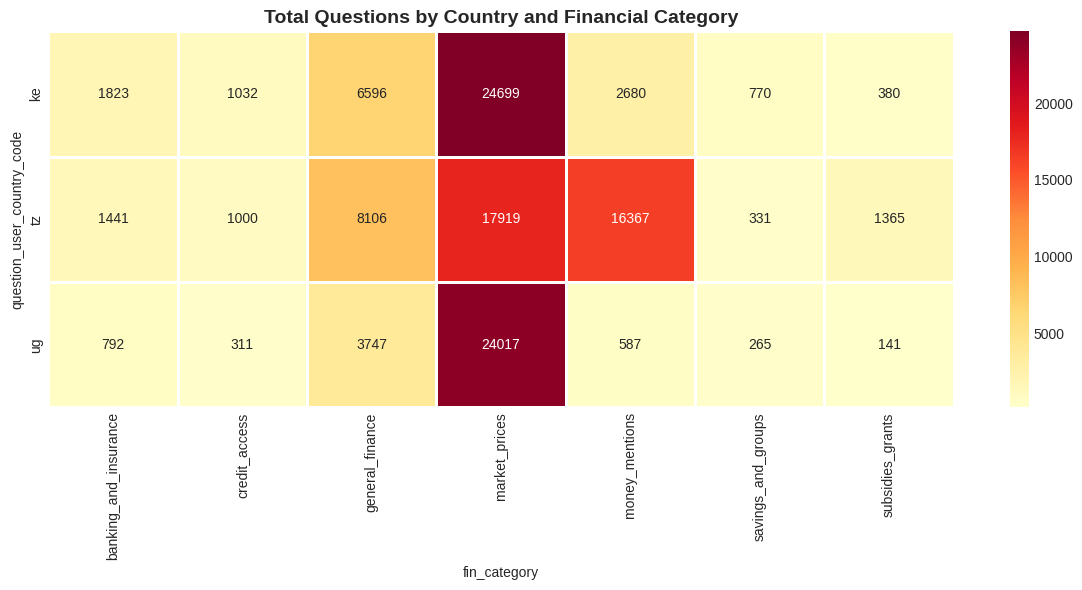

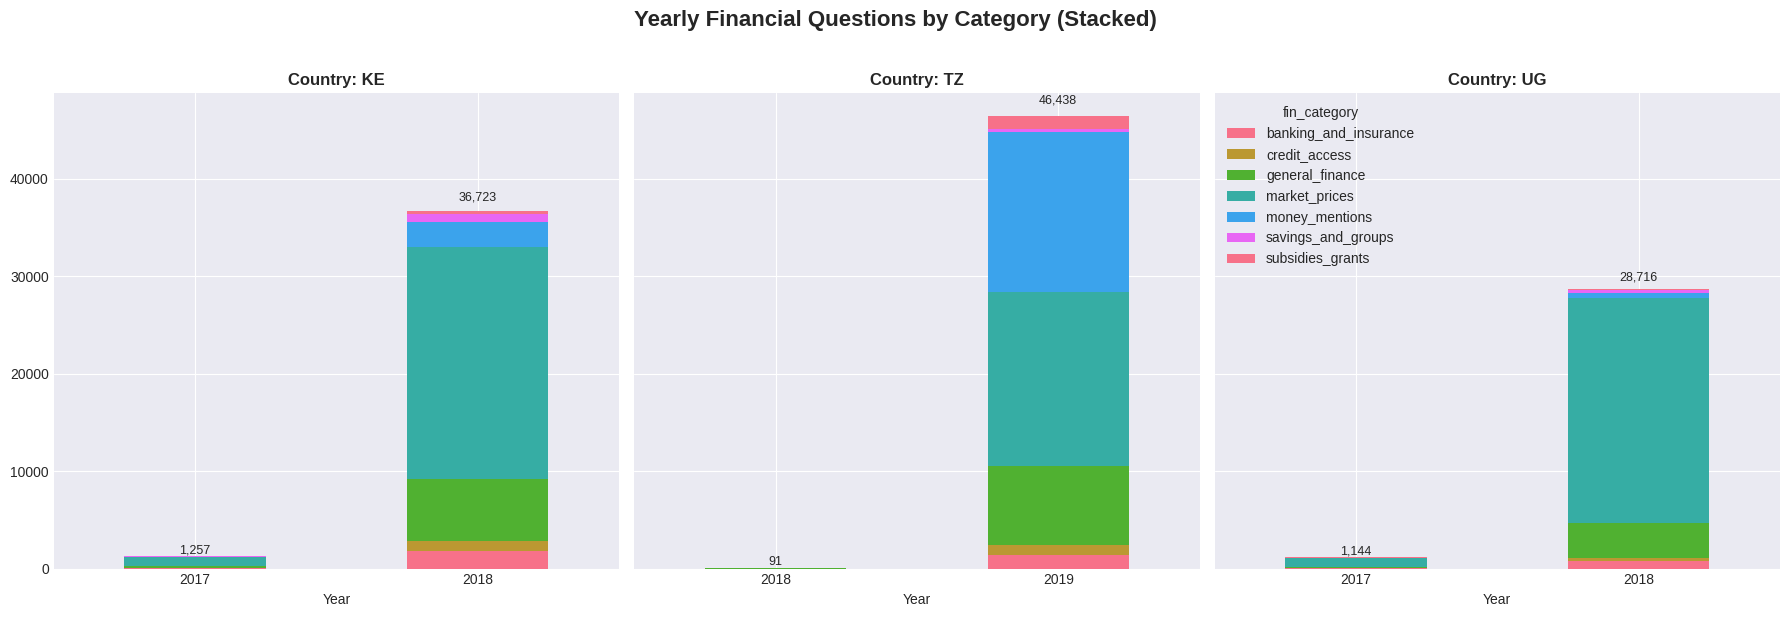

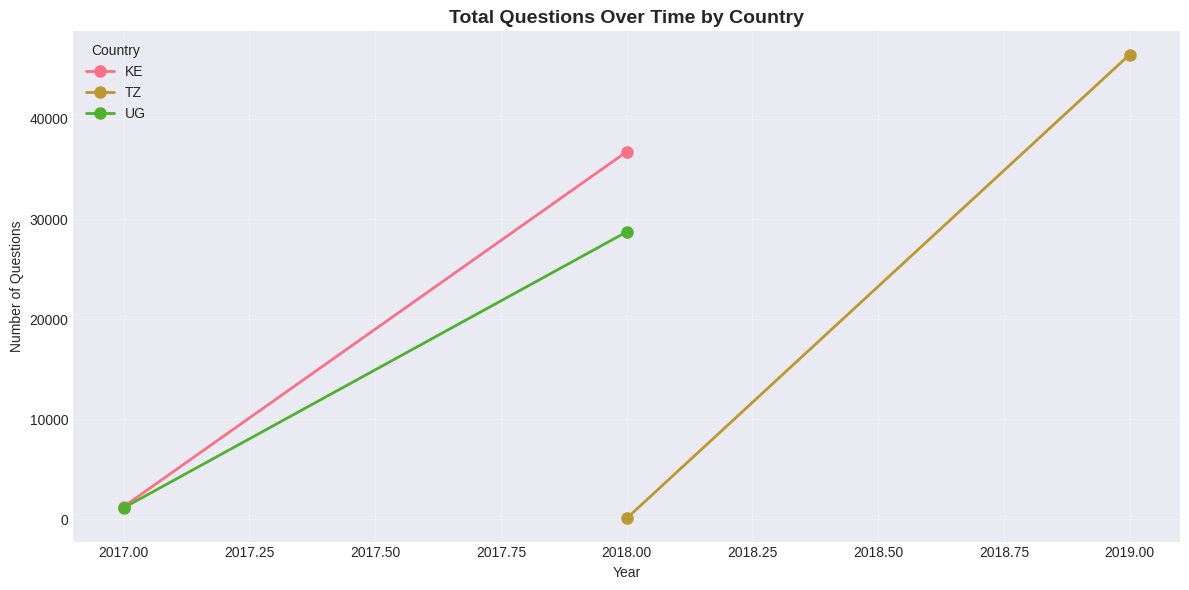

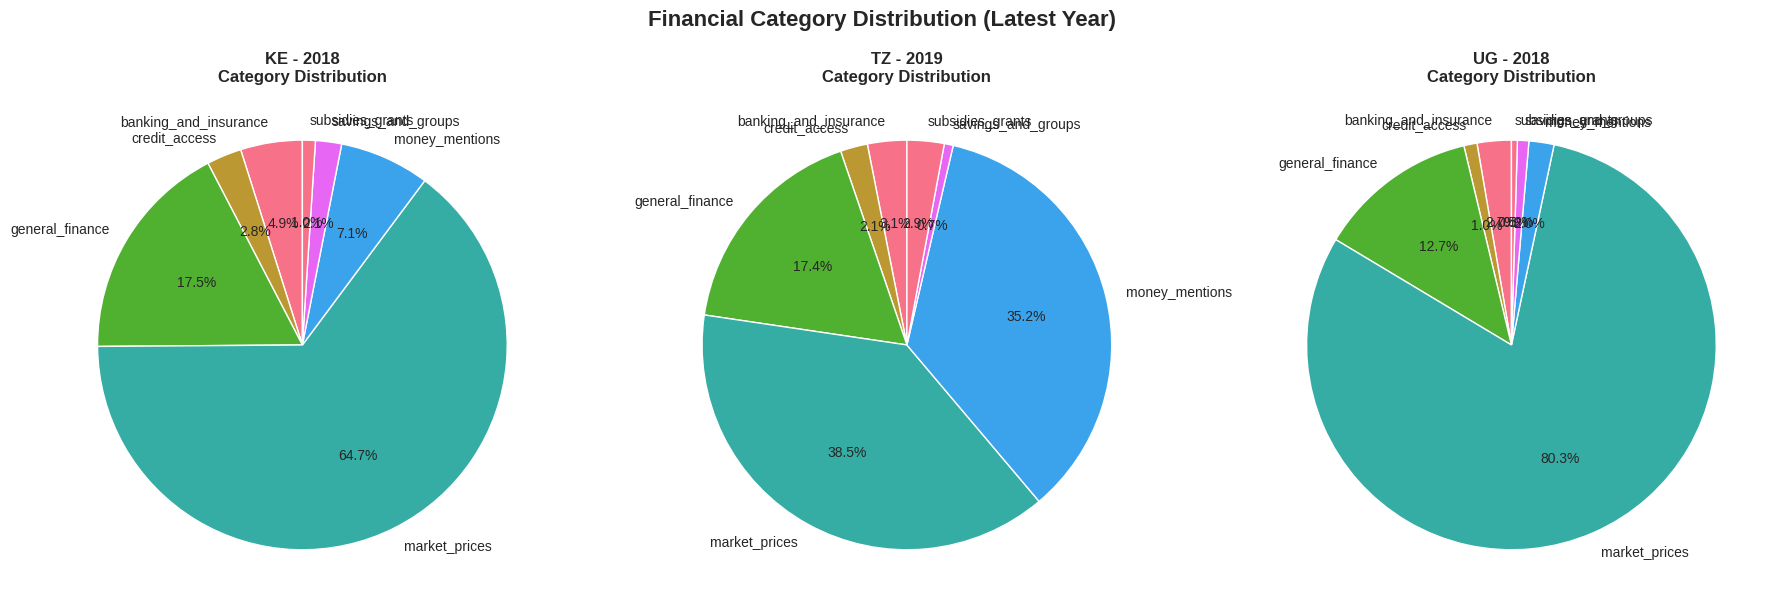

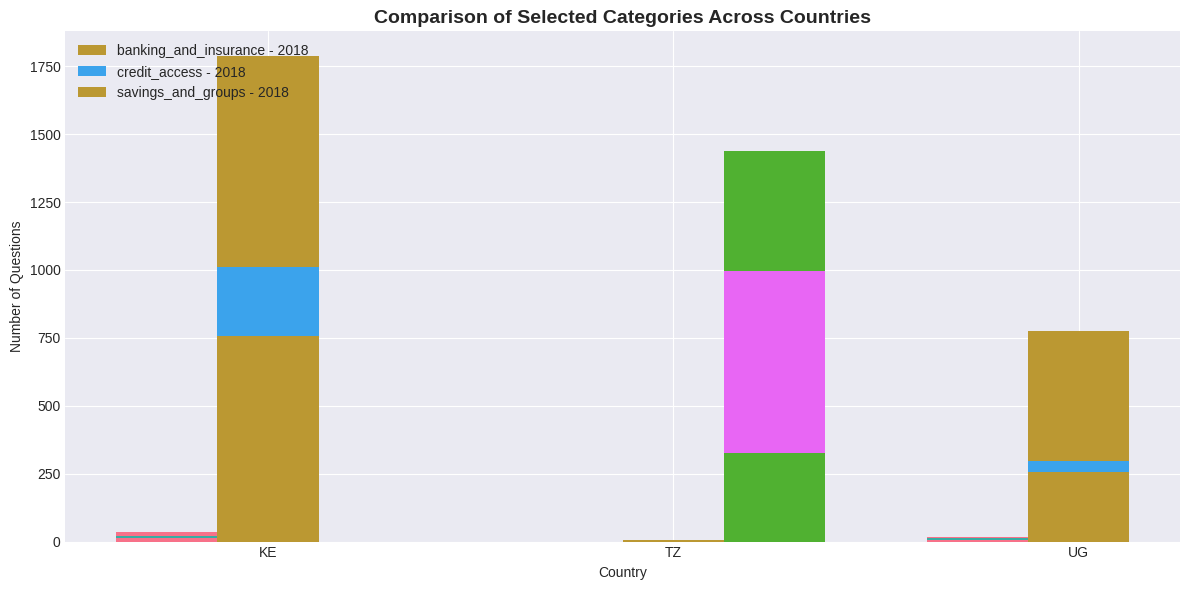

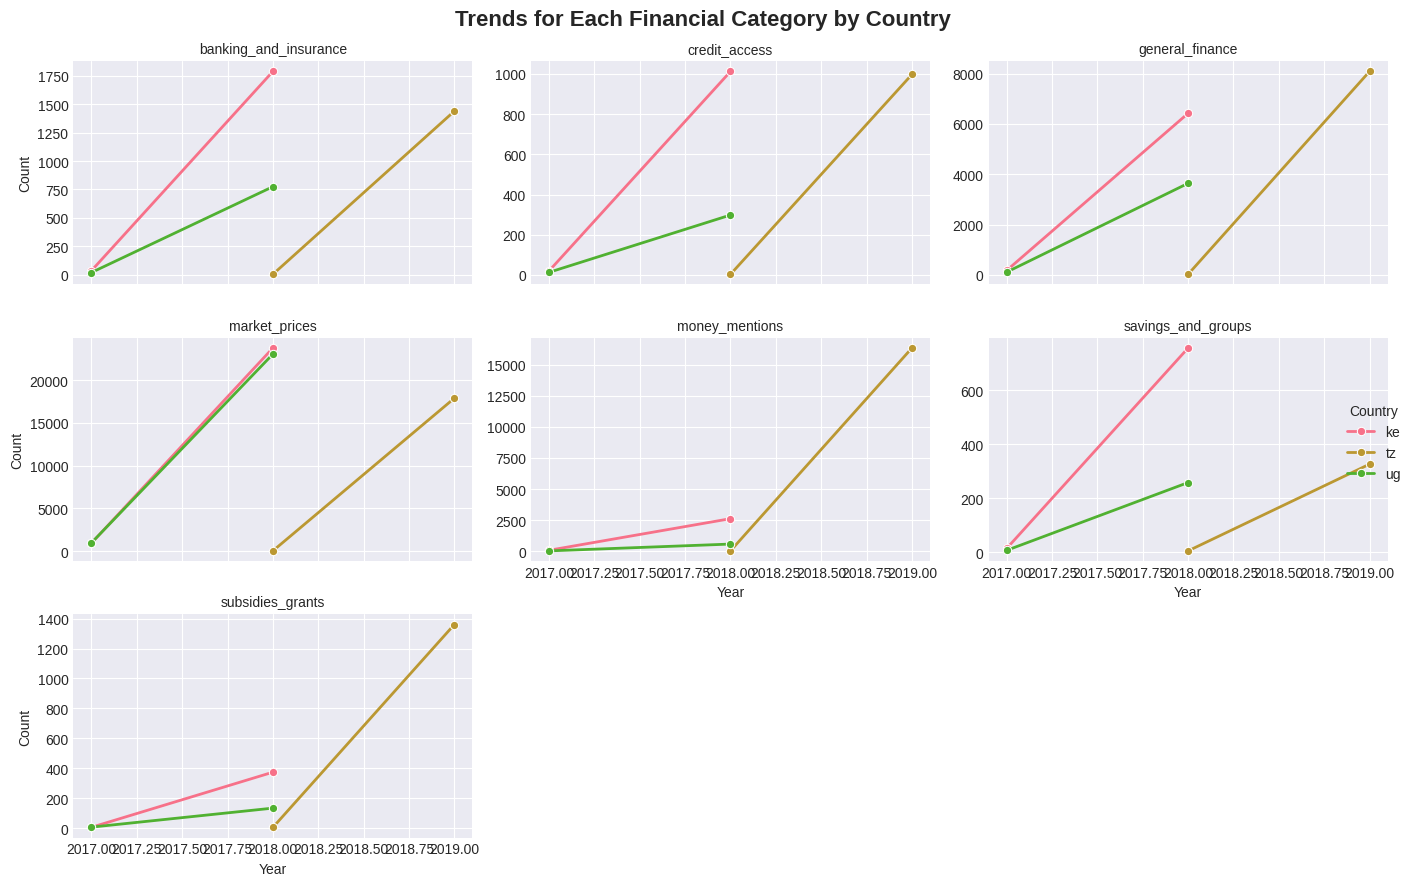


SUMMARY STATISTICS

Total questions by country:
question_user_country_code
ke    37980
tz    46529
ug    29860
Name: row_count, dtype: int64

Year-over-year growth by country:
KE: 2821.5% growth
TZ: 50930.8% growth
UG: 2410.1% growth

Most popular category by country:
KE: market_prices (24,699 questions)
TZ: market_prices (17,919 questions)
UG: market_prices (24,017 questions)


In [ ]:
# prev. step dataset visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create the dataset
data = {
    'question_user_country_code': ['ke']*14 + ['tz']*14 + ['ug']*14,
    'question_sent_year': [2017]*7 + [2018]*7 + [2018]*7 + [2019]*7 + [2017]*7 + [2018]*7,
    'fin_category': [
        'is_banking_and_insurance', 'is_credit_access', 'is_general_finance',
        'is_market_prices', 'is_money_mentions', 'is_savings_and_groups',
        'is_subsidies_grants'
    ] * 6,
    'row_count': [
        # Kenya
        34, 20, 174, 941, 68, 14, 6,
        1789, 1012, 6422, 23758, 2612, 756, 374,
        # Tanzania
        2, 3, 20, 36, 20, 5, 5,
        1439, 997, 8086, 17883, 16347, 326, 1360,
        # Uganda
        18, 13, 108, 972, 19, 7, 7,
        774, 298, 3639, 23045, 568, 258, 134
    ]
}

df = pd.DataFrame(data)

# Clean category names (remove 'is_' prefix)
df['fin_category'] = df['fin_category'].str.replace('is_', '')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Countries: {df['question_user_country_code'].unique()}")
print(f"Years: {df['question_sent_year'].unique()}")
print(f"Categories: {df['fin_category'].unique()}")
print("\nFirst few rows:")
print(df.head())

# 1. HEATMAP - Total counts by country and category
plt.figure(figsize=(12, 6))
heatmap_data = df.groupby(['question_user_country_code', 'fin_category'])['row_count'].sum().unstack()
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', linewidths=1)
plt.title('Total Questions by Country and Financial Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. STACKED BAR CHART - Yearly comparison by country
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

countries = ['ke', 'tz', 'ug']
for idx, country in enumerate(countries):
    country_data = df[df['question_user_country_code'] == country]
    pivot_data = country_data.pivot_table(
        index='question_sent_year',
        columns='fin_category',
        values='row_count',
        aggfunc='sum'
    )

    pivot_data.plot(kind='bar', stacked=True, ax=axes[idx], legend=False if idx < 2 else True)
    axes[idx].set_title(f'Country: {country.upper()}', fontweight='bold')
    axes[idx].set_xlabel('Year')
    axes[idx].tick_params(axis='x', rotation=0)

    # Add total numbers on top of bars
    for i, (year, row) in enumerate(pivot_data.iterrows()):
        total = row.sum()
        axes[idx].text(i, total * 1.02, f'{total:,}',
                      ha='center', va='bottom', fontsize=9)

plt.suptitle('Yearly Financial Questions by Category (Stacked)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 3. LINE CHART - Trend over years for each country
plt.figure(figsize=(12, 6))

for country in countries:
    country_data = df[df['question_user_country_code'] == country]
    yearly_totals = country_data.groupby('question_sent_year')['row_count'].sum()

    plt.plot(yearly_totals.index, yearly_totals.values,
             marker='o', linewidth=2, markersize=8, label=country.upper())

plt.title('Total Questions Over Time by Country', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Questions')
plt.legend(title='Country')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. PIE CHART - Category distribution for each country (latest year)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, country in enumerate(countries):
    # Get latest year for each country
    latest_year = df[df['question_user_country_code'] == country]['question_sent_year'].max()
    latest_data = df[(df['question_user_country_code'] == country) &
                    (df['question_sent_year'] == latest_year)]

    axes[idx].pie(latest_data['row_count'],
                  labels=latest_data['fin_category'],
                  autopct='%1.1f%%',
                  startangle=90,
                  wedgeprops={'edgecolor': 'white', 'linewidth': 1})
    axes[idx].set_title(f'{country.upper()} - {latest_year}\nCategory Distribution', fontweight='bold')

plt.suptitle('Financial Category Distribution (Latest Year)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 5. GROUPED BAR CHART - Compare specific categories across countries
selected_categories = ['banking_and_insurance', 'credit_access', 'savings_and_groups']
plt.figure(figsize=(12, 6))

for category in selected_categories:
    category_data = df[df['fin_category'] == category]
    pivot_data = category_data.pivot_table(
        index='question_user_country_code',
        columns='question_sent_year',
        values='row_count',
        aggfunc='sum'
    )

    x = np.arange(len(countries))
    width = 0.25

    for i, year in enumerate(sorted(pivot_data.columns)):
        offset = (i - 1) * width
        plt.bar(x + offset, pivot_data[year], width,
                label=f'{category} - {year}' if i == 1 else '')

plt.xlabel('Country')
plt.ylabel('Number of Questions')
plt.title('Comparison of Selected Categories Across Countries', fontsize=14, fontweight='bold')
plt.xticks(x, [c.upper() for c in countries])
plt.legend()
plt.tight_layout()
plt.show()

# 6. FACET GRID - Individual category trends
g = sns.FacetGrid(df, col='fin_category', col_wrap=3, height=3, aspect=1.5, sharey=False)
g.map_dataframe(sns.lineplot, x='question_sent_year', y='row_count',
                hue='question_user_country_code', marker='o', linewidth=2)
g.add_legend(title='Country')
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "Count")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trends for Each Financial Category by Country', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional insights - Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Total by country
print("\nTotal questions by country:")
country_totals = df.groupby('question_user_country_code')['row_count'].sum()
print(country_totals)

print("\nYear-over-year growth by country:")
for country in countries:
    country_data = df[df['question_user_country_code'] == country]
    yearly = country_data.groupby('question_sent_year')['row_count'].sum()
    if len(yearly) > 1:
        growth = ((yearly.iloc[-1] - yearly.iloc[0]) / yearly.iloc[0] * 100)
        print(f"{country.upper()}: {growth:.1f}% growth")

print("\nMost popular category by country:")
for country in countries:
    country_data = df[df['question_user_country_code'] == country]
    category_totals = country_data.groupby('fin_category')['row_count'].sum()
    top_category = category_totals.idxmax()
    print(f"{country.upper()}: {top_category} ({category_totals.max():,} questions)")

### Visualization 2

In [ ]:
# Viz 2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# -----------------------------
#  SETTINGS
# -----------------------------
PALETTE_A4 = ["#6a8e7f", "#d0b49f", "#f2d0a9", "#4a536b", "#9c9c9c"]

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.grid": True,
    "grid.alpha": 0.2,
    "axes.edgecolor": "#dddddd",
    "axes.linewidth": 1.2,
    "font.size": 12,
})

OUTPUT_DIR = "charts_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


# -----------------------------
#  HELPER FUNCTIONS
# -----------------------------

# -----------------------------
#  RENAME DF COLUMNS
# -----------------------------
def normalize_df(df):
    """Rename your dataframe into the expected schema."""
    df = df.rename(columns={
        "question_user_country_code": "country",
        "question_sent_year": "year",
        "fin_category": "dimension",
        "row_count": "value",
    })
    return df

def safe_pivot(df, index, columns, values):
    """Pivot and fill missing combinations safely."""
    p = df.pivot_table(index=index, columns=columns, values=values, aggfunc="sum")
    p = p.reindex(sorted(p.index), fill_value=0)
    p = p.reindex(sorted(p.columns), axis=1, fill_value=0)
    return p

def save_fig(name):
    """Save as PNG and SVG."""
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{name}.png"), dpi=300)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{name}.svg"))
    plt.show()

# -----------------------------
#  LOAD YOUR DATA
# -----------------------------
# Replace with your dataframe
# df = pd.read_csv("your_file.csv")

# Example structure expected:
# df columns: ["country", "year", "dimension", "value"]

# -----------------------------
# 1. Small-Multiples Stacked Bars
# -----------------------------
def chart_small_multiples(df):
    pivot = safe_pivot(df, "year", "dimension", "value")
    n_dim = len(pivot.columns)

    fig, axes = plt.subplots(n_dim, 1, figsize=(14, 3*n_dim), sharex=True)

    for i, dim in enumerate(pivot.columns):
        ax = axes[i]
        ax.bar(pivot.index, pivot[dim], color=PALETTE_A4[i % len(PALETTE_A4)])
        ax.set_title(dim, fontweight=600)
        ax.set_ylabel("Value")

    plt.suptitle("Small Multiples — Each Dimension by Year", fontsize=16, fontweight=700)
    save_fig("small_multiples")

# -----------------------------
# 2. Grouped Bars (Dimensions grouped within Year)
# -----------------------------
def chart_grouped(df):
    pivot = safe_pivot(df, "year", "dimension", "value")
    x = np.arange(len(pivot.index))
    w = 0.8 / len(pivot.columns)

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, dim in enumerate(pivot.columns):
        ax.bar(x + i*w, pivot[dim], width=w, label=dim, color=PALETTE_A4[i % len(PALETTE_A4)])

    ax.set_xticks(x + w*(len(pivot.columns)/2))
    ax.set_xticklabels(pivot.index)
    ax.set_title("Grouped Bars — Dimensions per Year", fontweight=700)
    ax.legend()

    save_fig("grouped_bars")

# -----------------------------
# 3. Clean Heatmap
# -----------------------------
def chart_heatmap(df):
    pivot = safe_pivot(df, "dimension", "year", "value")

    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(pivot, aspect="auto")

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_title("Heatmap — Dimension vs Year", fontweight=700)

    fig.colorbar(im, ax=ax)
    save_fig("heatmap")

# -----------------------------
# 4. Faceted Bars (One panel per dimension)
# -----------------------------
def chart_facet(df):
    dims = df["dimension"].unique()
    fig, axes = plt.subplots(len(dims), 1, figsize=(14, 3*len(dims)), sharex=True)

    for ax, dim in zip(axes, dims):
        sub = df[df["dimension"] == dim]
        for i, c in enumerate(sub["country"].unique()):
            s2 = sub[sub["country"] == c]
            ax.plot(s2["year"], s2["value"], marker="o", color=PALETTE_A4[i % len(PALETTE_A4)], label=c)

        ax.set_title(dim, fontweight=600)
        ax.legend()

    plt.suptitle("Faceted Line Panels by Dimension", fontsize=16, fontweight=700)
    save_fig("facet_panels")

# -----------------------------
# 5. Country-Year Grid (Trellis)
# -----------------------------
def chart_country_grid(df):
    countries = df["country"].unique()
    n = len(countries)

    fig, axes = plt.subplots(n, 1, figsize=(14, 3*n), sharex=True)

    for ax, c in zip(axes, countries):
        sub = df[df["country"] == c]
        for i, dim in enumerate(sub["dimension"].unique()):
            s2 = sub[sub["dimension"] == dim]
            ax.plot(s2["year"], s2["value"], marker="o", color=PALETTE_A4[i % len(PALETTE_A4)], label=dim)

        ax.set_title(c, fontweight=600)
        ax.legend()

    plt.suptitle("Country-Year Trellis Grid", fontsize=16, fontweight=700)
    save_fig("country_grid")

# -----------------------------
# 6. Soft Streamgraph / Stacked Area
# -----------------------------
def chart_stream(df):
    pivot = safe_pivot(df, "year", "dimension", "value")

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.stackplot(pivot.index, pivot.values.T, labels=pivot.columns, colors=PALETTE_A4[:len(pivot.columns)])
    ax.set_title("Streamgraph / Soft Area Chart", fontweight=700)
    ax.legend()

    save_fig("streamgraph")

# -----------------------------
# RUN ALL CHARTS
# -----------------------------
def run_all_charts(df):
    chart_small_multiples(df)
    chart_grouped(df)
    chart_heatmap(df)
    chart_facet(df)
    chart_country_grid(df)
    chart_stream(df)


# -----------------------------
# MAIN EXECUTION
# -----------------------------
def run_all_charts(df):
    df = normalize_df(df)
    chart_small_multiples(df)
    chart_grouped(df)
    chart_heatmap(df)
    chart_facet(df)
    chart_country_grid(df)
    chart_stream(df)
# Call:
# run_all_charts(df)


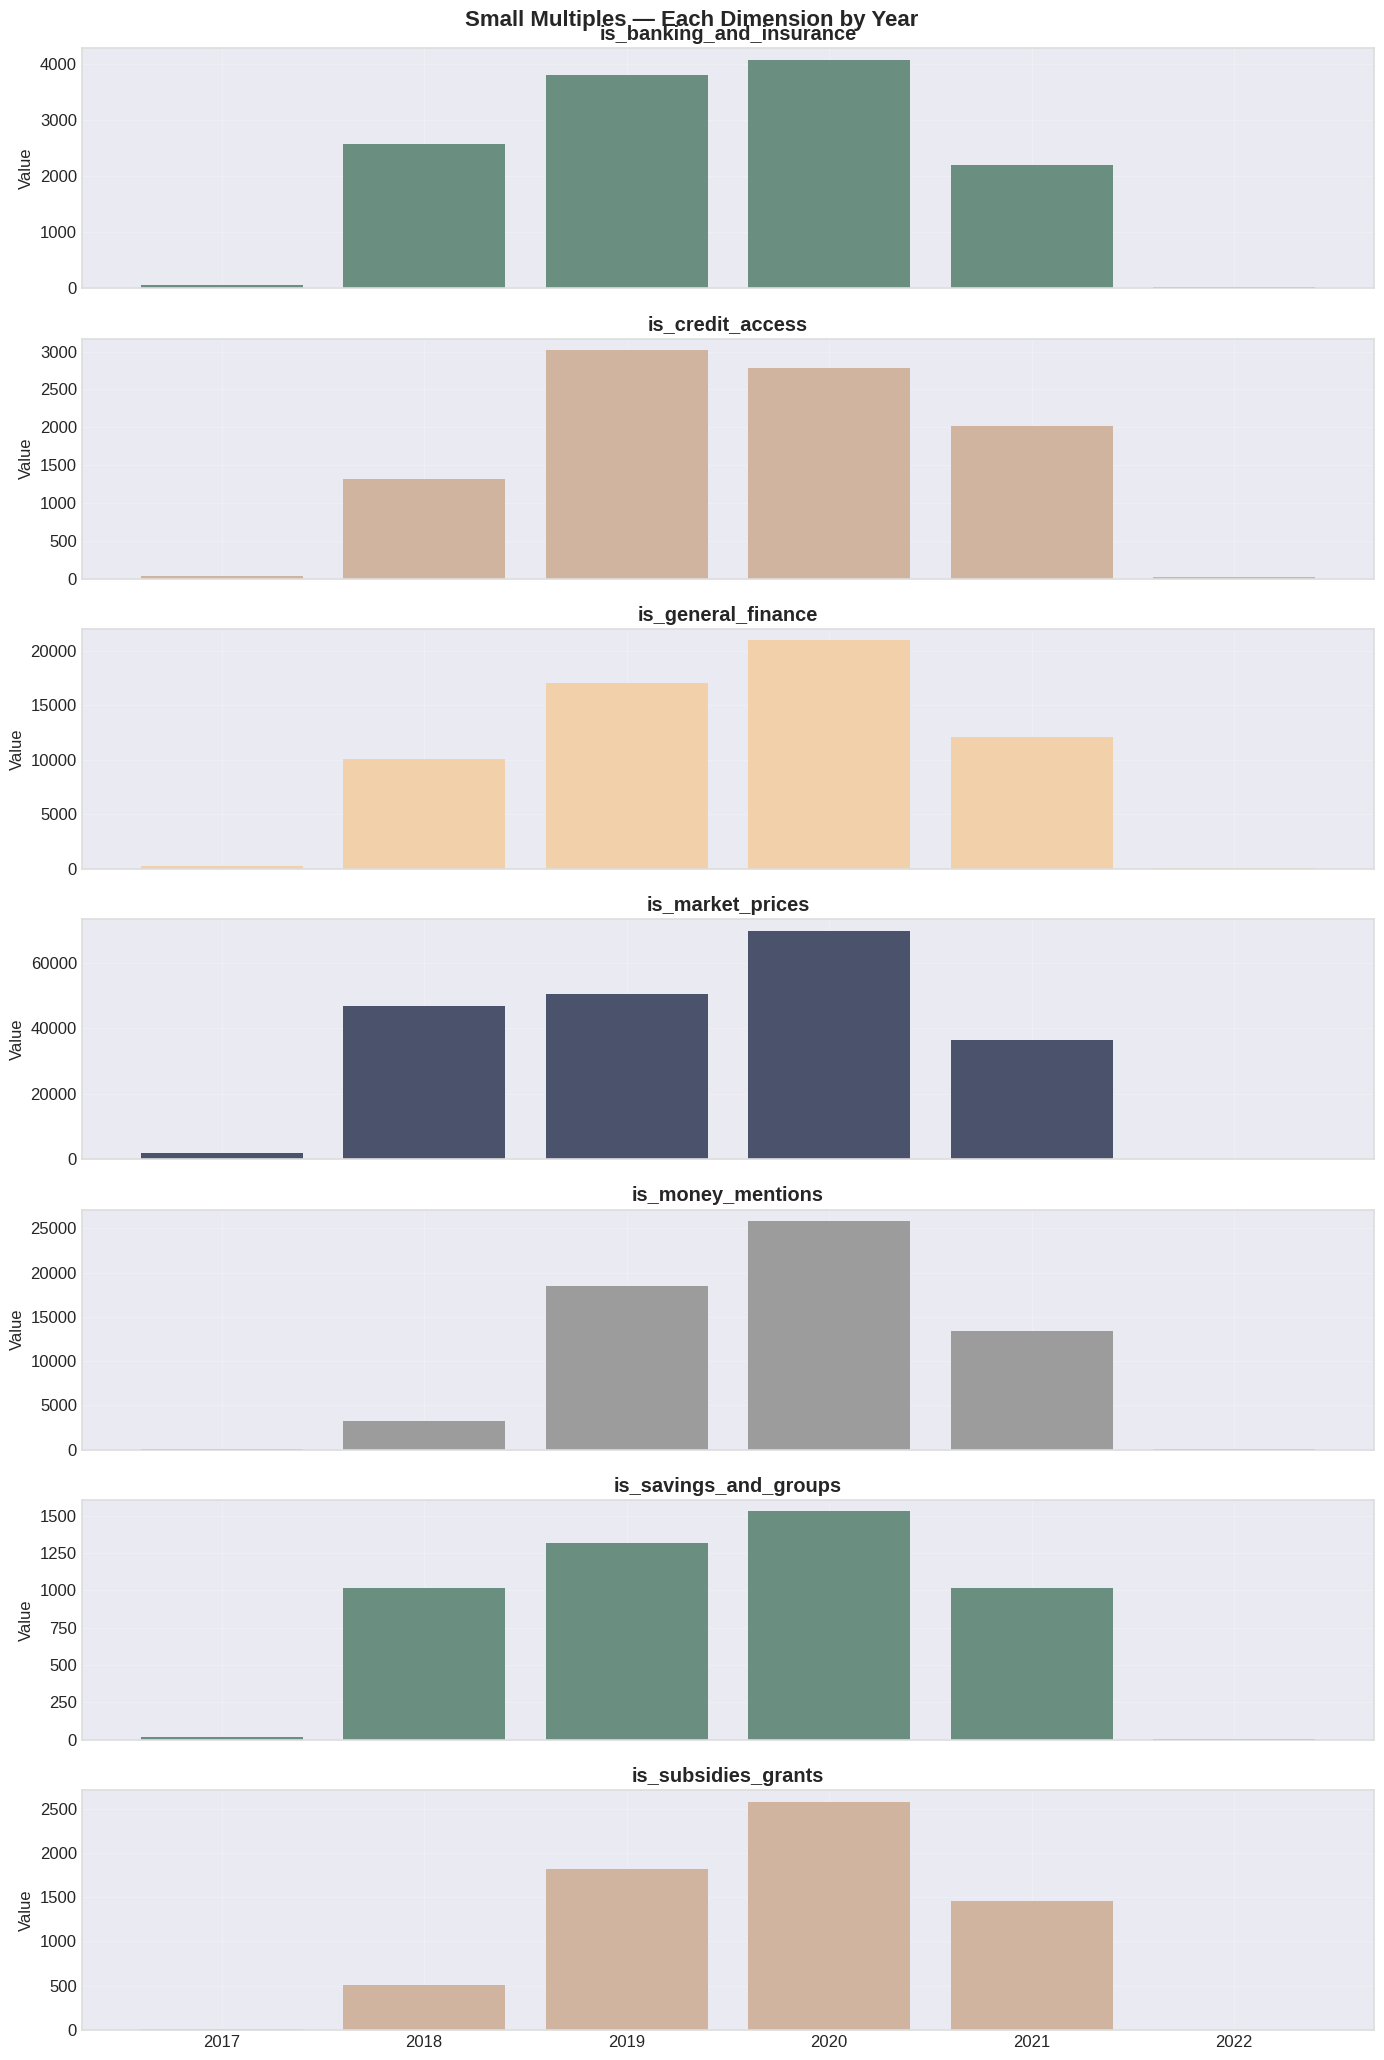

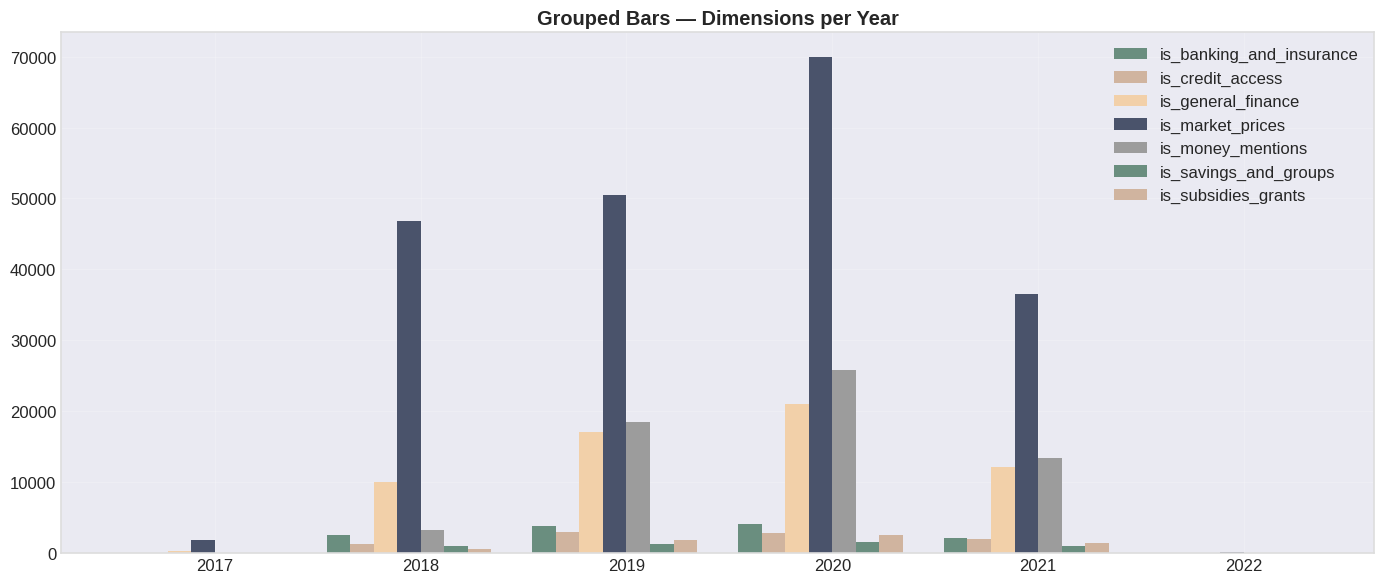

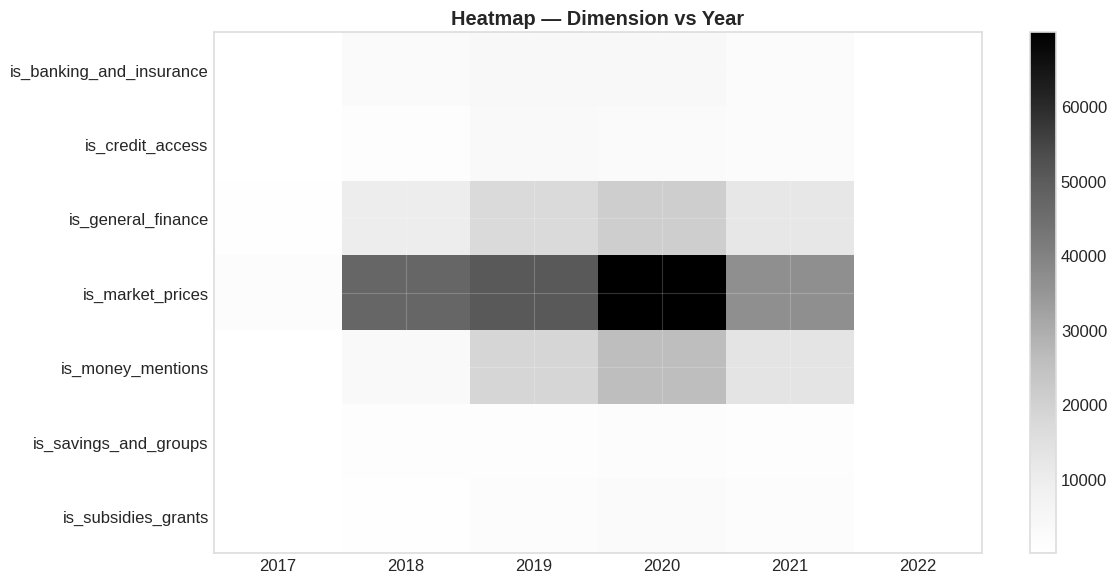

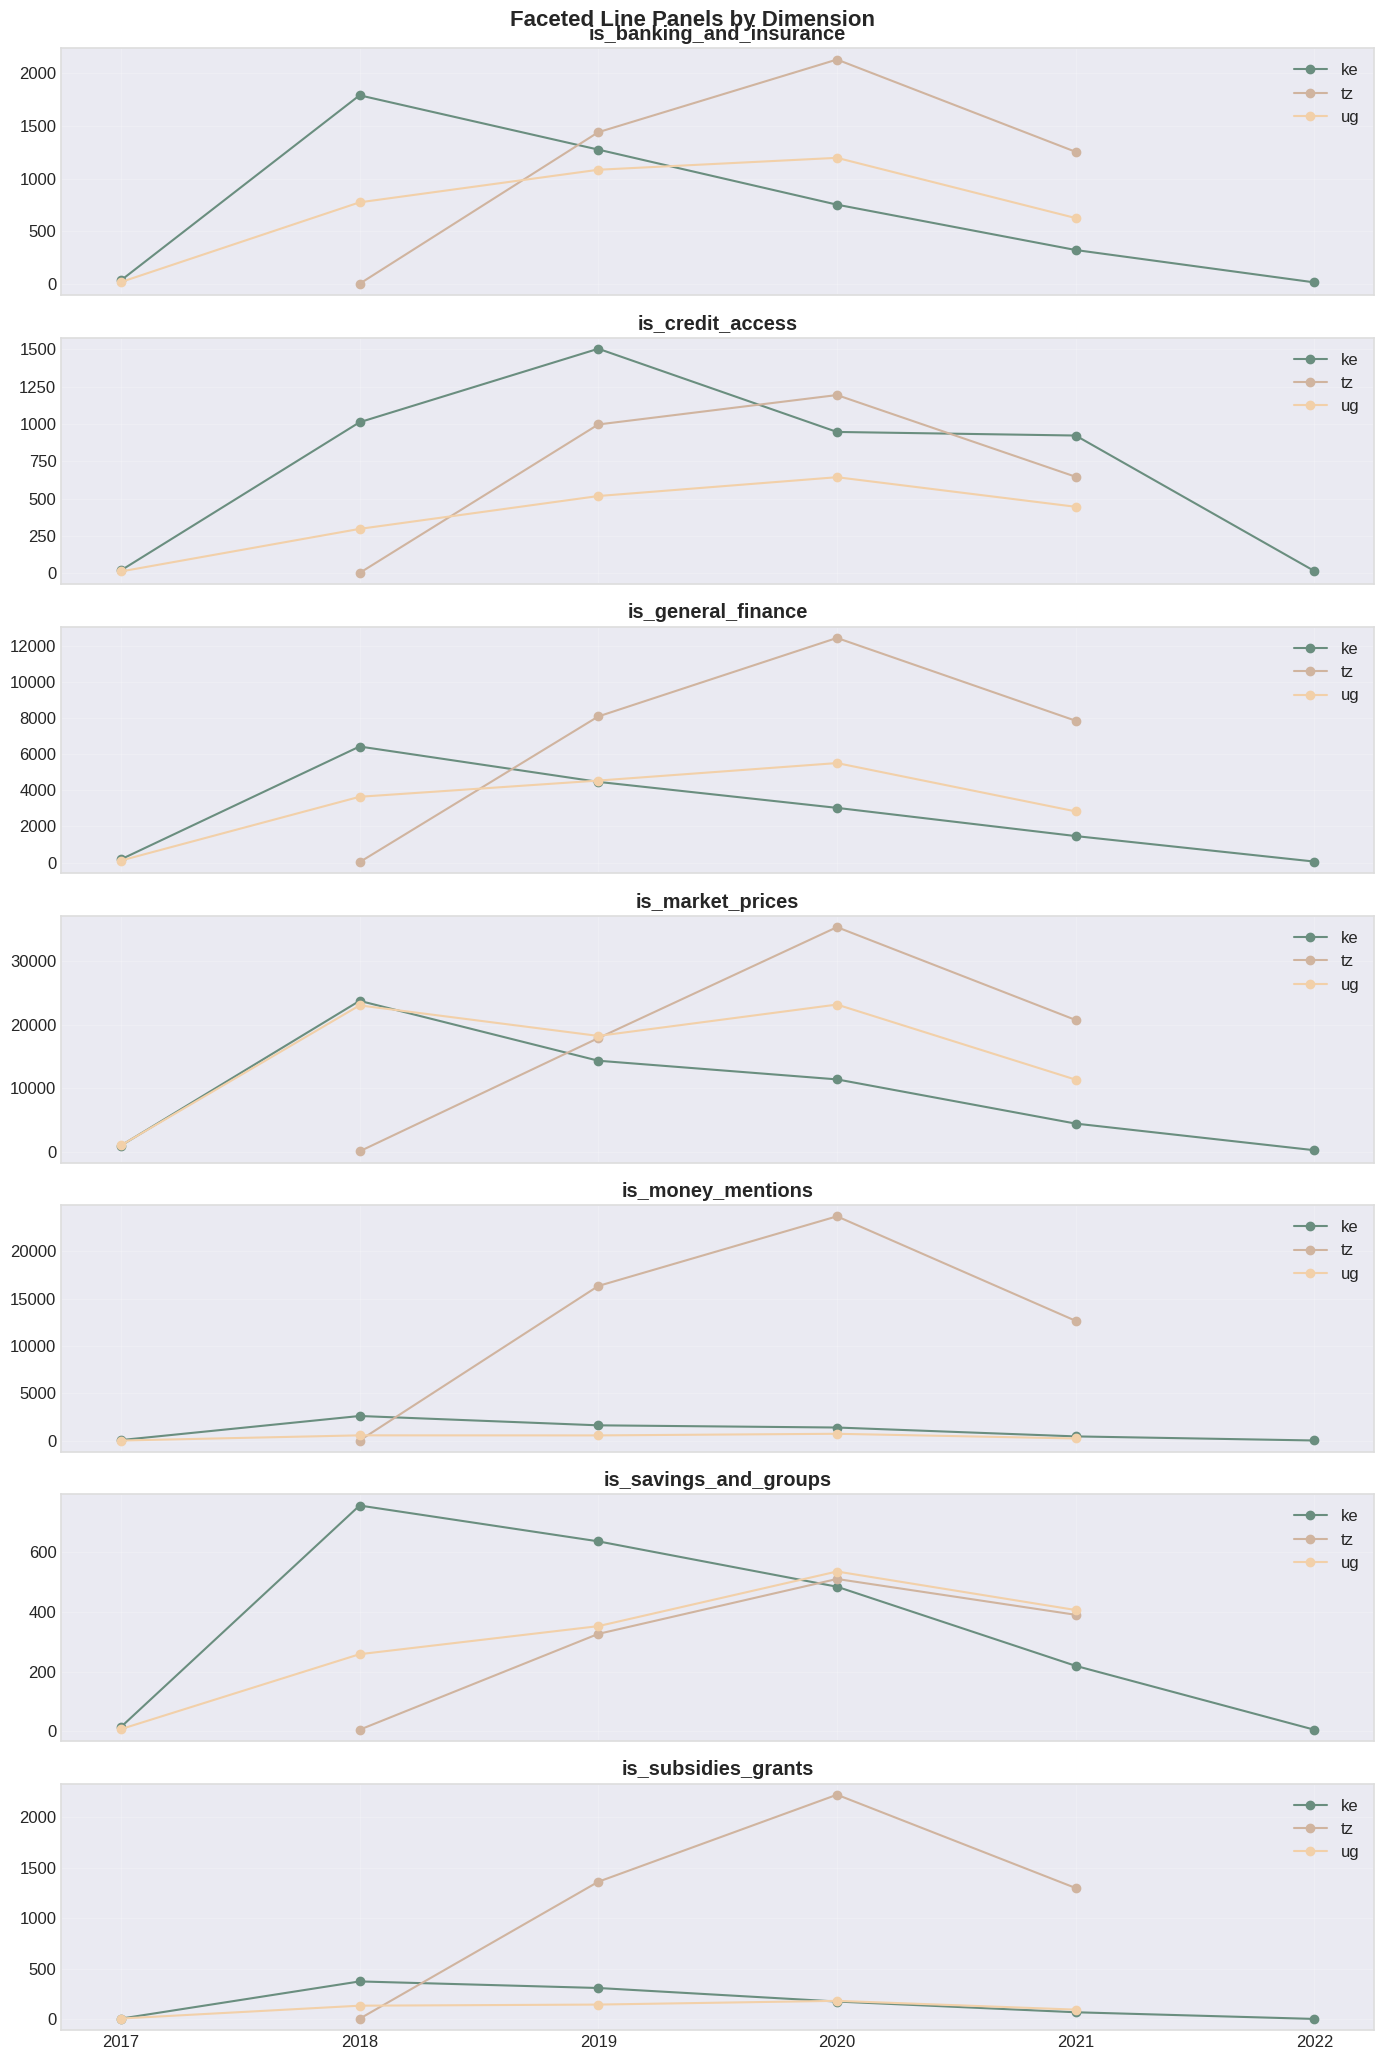

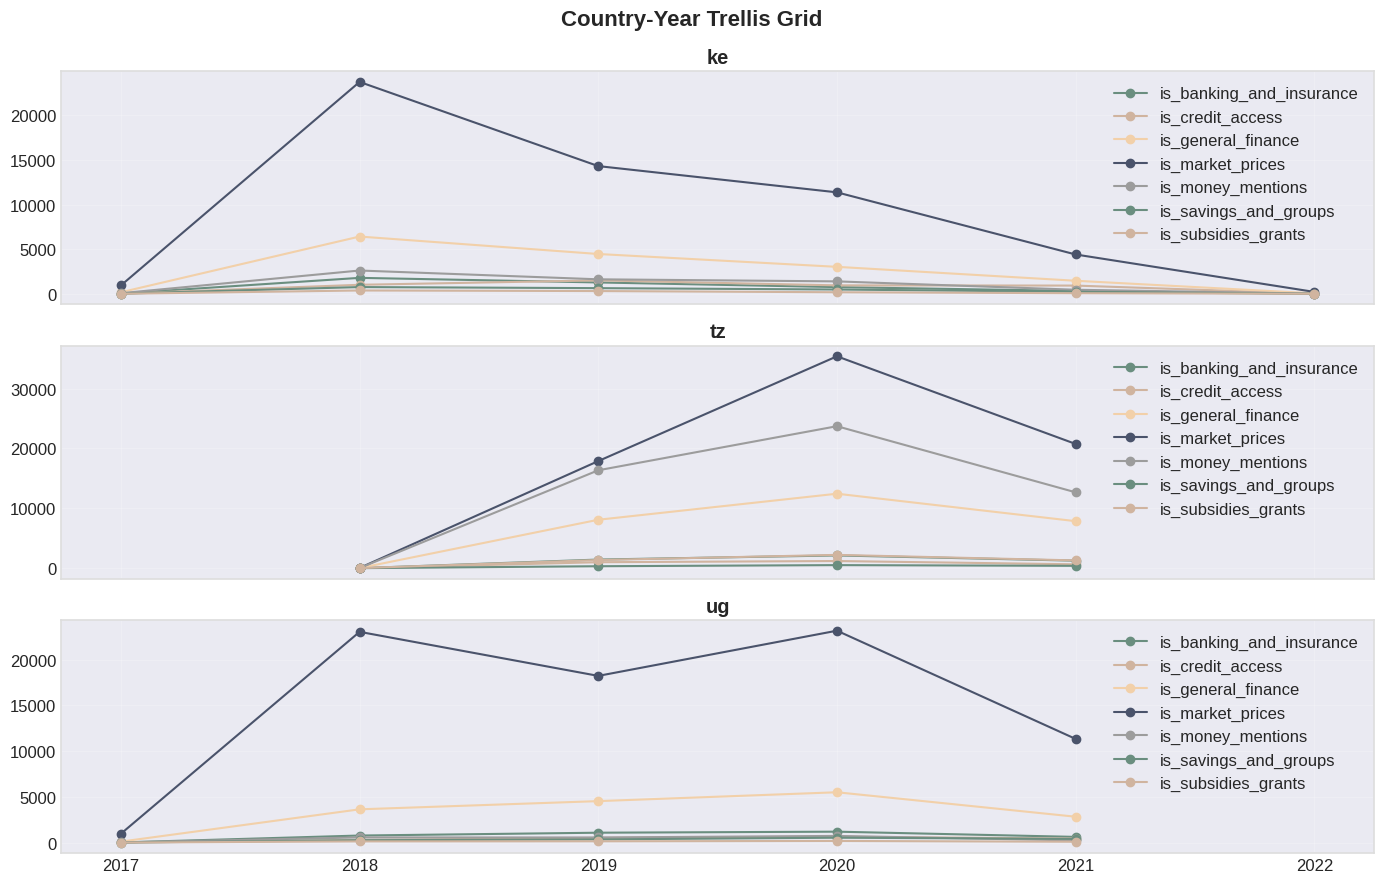

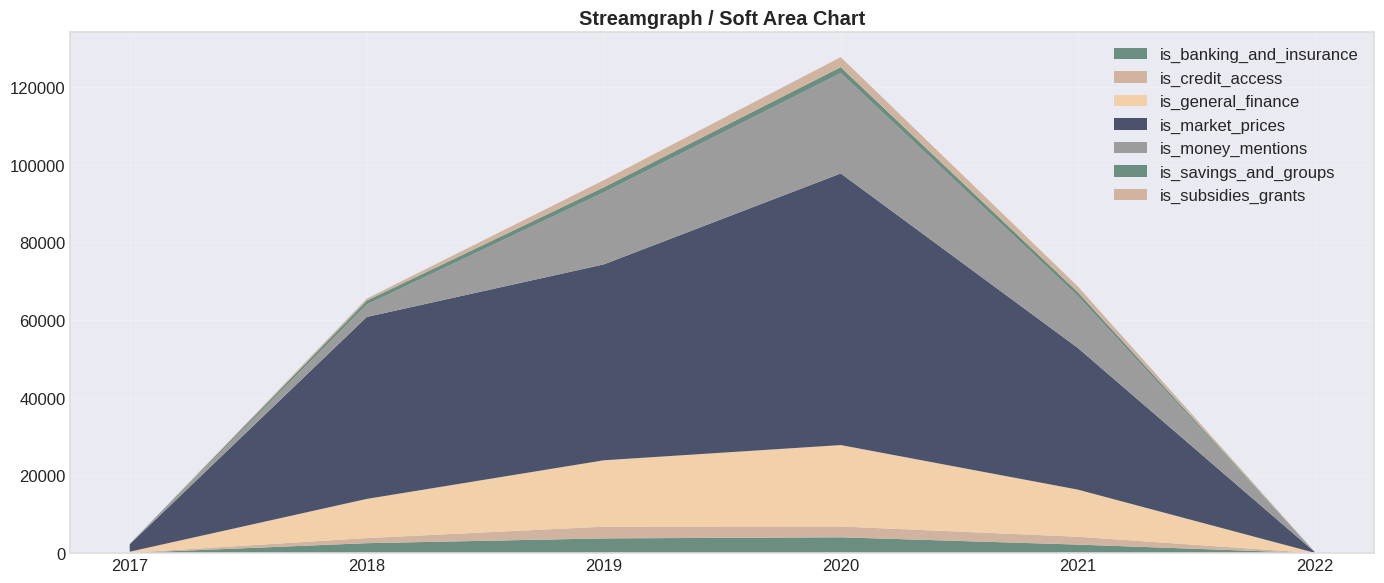

In [ ]:
# Run all charts
run_all_charts(query_results)